In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"

# For Sample Score
TRIM_ER = 500
TOTAL_EPOCH = 600
# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-11-28 17:04:26,077 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-11-28 17:04:27,330 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-11-28 17:04:27,334 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
# Setting up task dict for task-aware
memory_buffer.task_dict = {
    0: list(range(5, 9)), # AG
    1: list(range(0, 5)), # Amazon
    2: list(range(0, 5)), # Yelp
    3: list(range(9, 23)), # DBPedia
    4: list(range(23, 33)), # Yahoo
}

In [8]:
# label to task converter - hack, since normally we would just use the task token/identifier
def get_task_from_label(label_idx, task_dict):
    for task_idx, class_list in task_dict.items():
        if label_idx in class_list: return task_idx
    return -1
print(get_task_from_label(8, memory_buffer.task_dict))
# Find mode: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
def mode(array):
    return max(array, key = array.count)
# label list to task id
def get_task_from_label_list(label_list, task_dict):
    return mode([get_task_from_label(label, task_dict) for label in label_list])
print(get_task_from_label_list([1,2,32,1,4,2,0], memory_buffer.task_dict))

0
1


In [9]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [10]:
# Trim buffer dict to 1000 per class
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict(limit_n=TRIM_ER)

In [11]:
len(memory_buffer.buffer_dict[0])

500

# Get Scores for each sample in ER

In [12]:
# Returns loss,preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `16*1 = 16` batch , there are 5 tasks so `16*5 = 80` per epoch (takes around 0.2s per task ~1s). So we need to do it 300 times so that it will be ~5 minutes (300s) and it means `80*300 = 24,000`, and hopefully support will be around  `16*300/300 ~ 16` per sample.

```
Adapt Time: 0.165510892868042 s
Support set metrics: Loss = 0.3509, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
```

```
For 600 Epoch
Total Scoring Time: 29.0 m
```

In [13]:
TIC_score = time.time()
for epoch in range(TOTAL_EPOCH):
    print(f"This is epoch {epoch}/{TOTAL_EPOCH}")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        #for _ in range(updates):
        for _ in range(1): # CHANGE THIS to 1 minibatch.
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, \
                                                                  with_index=True)
            support_set.append((text, labels, indexes))
        
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, diff_list)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

TOC_score = time.time() - TIC_score 
print("Total Scoring Time: "+ str(TOC_score//60) +" m" )

This is epoch 0/600
Adapt Time: 0.1737689971923828 s
Support set metrics: Loss = 0.1472, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2063593864440918 s
Support set metrics: Loss = 1.1926, accuracy = 0.5625, precision = 0.6867, recall = 0.5500, F1 score = 0.5743
Adapt Time: 0.21673583984375 s
Support set metrics: Loss = 1.0968, accuracy = 0.5625, precision = 0.6333, recall = 0.5667, F1 score = 0.5571
Adapt Time: 0.1852414608001709 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1921062469482422 s
Support set metrics: Loss = 0.4191, accuracy = 0.8750, precision = 0.8167, recall = 0.8500, F1 score = 0.8133
This is epoch 1/600
Adapt Time: 0.17055368423461914 s
Support set metrics: Loss = 0.3647, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2014784812927246 s
Support set metrics: Loss = 0.6718, accuracy = 0.8125, precision = 0.7

Adapt Time: 0.20013427734375 s
Support set metrics: Loss = 0.6563, accuracy = 0.7500, precision = 0.7500, recall = 0.7500, F1 score = 0.7429
Adapt Time: 0.2014601230621338 s
Support set metrics: Loss = 0.8190, accuracy = 0.7500, precision = 0.7833, recall = 0.7333, F1 score = 0.7190
Adapt Time: 0.17616605758666992 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22463560104370117 s
Support set metrics: Loss = 1.1994, accuracy = 0.5625, precision = 0.3333, recall = 0.5000, F1 score = 0.3933
This is epoch 12/600
Adapt Time: 0.17286372184753418 s
Support set metrics: Loss = 0.1102, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19372105598449707 s
Support set metrics: Loss = 0.7863, accuracy = 0.7500, precision = 0.8500, recall = 0.7500, F1 score = 0.7529
Adapt Time: 0.20786404609680176 s
Support set metrics: Loss = 0.6144, accuracy = 0.7500, precision = 0.7867, recall = 0

Adapt Time: 0.188079833984375 s
Support set metrics: Loss = 0.7430, accuracy = 0.7500, precision = 0.8033, recall = 0.7500, F1 score = 0.7533
Adapt Time: 0.17727398872375488 s
Support set metrics: Loss = 0.0162, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2167813777923584 s
Support set metrics: Loss = 0.9505, accuracy = 0.6875, precision = 0.6333, recall = 0.7000, F1 score = 0.6600
This is epoch 23/600
Adapt Time: 0.17246103286743164 s
Support set metrics: Loss = 0.1702, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2080075740814209 s
Support set metrics: Loss = 1.2940, accuracy = 0.6250, precision = 0.7333, recall = 0.6333, F1 score = 0.6476
Adapt Time: 0.20990347862243652 s
Support set metrics: Loss = 1.0517, accuracy = 0.4375, precision = 0.5633, recall = 0.4333, F1 score = 0.4514
Adapt Time: 0.18964672088623047 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.17836284637451172 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20659422874450684 s
Support set metrics: Loss = 0.7411, accuracy = 0.8750, precision = 0.9333, recall = 0.9000, F1 score = 0.8833
This is epoch 34/600
Adapt Time: 0.17269611358642578 s
Support set metrics: Loss = 0.4968, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8730
Adapt Time: 0.22520089149475098 s
Support set metrics: Loss = 0.6615, accuracy = 0.8125, precision = 0.8333, recall = 0.8167, F1 score = 0.8148
Adapt Time: 0.21340036392211914 s
Support set metrics: Loss = 0.6693, accuracy = 0.6875, precision = 0.5900, recall = 0.6667, F1 score = 0.6092
Adapt Time: 0.18024992942810059 s
Support set metrics: Loss = 0.0240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22648859024047852 s
Support set metrics: Loss = 0.4636, accuracy = 0.8750, precision = 0.9500, recall

Adapt Time: 0.2023777961730957 s
Support set metrics: Loss = 0.8820, accuracy = 0.7500, precision = 0.7400, recall = 0.7500, F1 score = 0.7238
This is epoch 45/600
Adapt Time: 0.17031478881835938 s
Support set metrics: Loss = 0.4694, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.19989609718322754 s
Support set metrics: Loss = 0.6653, accuracy = 0.8125, precision = 0.8533, recall = 0.8167, F1 score = 0.8148
Adapt Time: 0.1969127655029297 s
Support set metrics: Loss = 0.7569, accuracy = 0.7500, precision = 0.7533, recall = 0.7500, F1 score = 0.7348
Adapt Time: 0.18700265884399414 s
Support set metrics: Loss = 0.2664, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.20523285865783691 s
Support set metrics: Loss = 0.2908, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
This is epoch 46/600
Adapt Time: 0.1804659366607666 s
Support set metrics: Loss = 0.1828, accuracy = 0.8750, precisio

Adapt Time: 0.17332744598388672 s
Support set metrics: Loss = 0.3834, accuracy = 0.8750, precision = 0.9500, recall = 0.8750, F1 score = 0.8889
Adapt Time: 0.21260762214660645 s
Support set metrics: Loss = 1.0541, accuracy = 0.5625, precision = 0.5333, recall = 0.5667, F1 score = 0.5143
Adapt Time: 0.20812439918518066 s
Support set metrics: Loss = 1.2868, accuracy = 0.4375, precision = 0.4667, recall = 0.4333, F1 score = 0.4222
Adapt Time: 0.18129396438598633 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21904420852661133 s
Support set metrics: Loss = 1.0741, accuracy = 0.7500, precision = 0.6500, recall = 0.7000, F1 score = 0.6467
This is epoch 57/600
Adapt Time: 0.17026591300964355 s
Support set metrics: Loss = 0.7448, accuracy = 0.8125, precision = 0.8250, recall = 0.8125, F1 score = 0.8115
Adapt Time: 0.2157001495361328 s
Support set metrics: Loss = 1.4885, accuracy = 0.4375, precision = 0.5467, recall 

Adapt Time: 0.21754169464111328 s
Support set metrics: Loss = 0.8600, accuracy = 0.5625, precision = 0.4900, recall = 0.5500, F1 score = 0.5143
Adapt Time: 0.19775104522705078 s
Support set metrics: Loss = 1.0946, accuracy = 0.6250, precision = 0.6333, recall = 0.6167, F1 score = 0.5981
Adapt Time: 0.1794424057006836 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21294164657592773 s
Support set metrics: Loss = 1.1923, accuracy = 0.6875, precision = 0.6250, recall = 0.7000, F1 score = 0.6233
This is epoch 68/600
Adapt Time: 0.17224597930908203 s
Support set metrics: Loss = 0.1786, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2089693546295166 s
Support set metrics: Loss = 1.1868, accuracy = 0.4375, precision = 0.4000, recall = 0.4333, F1 score = 0.4143
Adapt Time: 0.21881961822509766 s
Support set metrics: Loss = 0.7632, accuracy = 0.6875, precision = 0.7300, recall =

Adapt Time: 0.1878199577331543 s
Support set metrics: Loss = 1.0737, accuracy = 0.5000, precision = 0.4067, recall = 0.4833, F1 score = 0.4300
Adapt Time: 0.17719125747680664 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2231762409210205 s
Support set metrics: Loss = 0.7749, accuracy = 0.8125, precision = 0.7833, recall = 0.8000, F1 score = 0.7600
This is epoch 79/600
Adapt Time: 0.17592692375183105 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18793892860412598 s
Support set metrics: Loss = 1.1261, accuracy = 0.4375, precision = 0.4500, recall = 0.4333, F1 score = 0.4038
Adapt Time: 0.19748258590698242 s
Support set metrics: Loss = 0.8374, accuracy = 0.6875, precision = 0.6600, recall = 0.6667, F1 score = 0.6578
Adapt Time: 0.18344998359680176 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.16686558723449707 s
Support set metrics: Loss = 0.0196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19218707084655762 s
Support set metrics: Loss = 0.5232, accuracy = 0.7500, precision = 0.5833, recall = 0.7000, F1 score = 0.6267
This is epoch 90/600
Adapt Time: 0.16858434677124023 s
Support set metrics: Loss = 0.1159, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2002546787261963 s
Support set metrics: Loss = 0.7913, accuracy = 0.6875, precision = 0.7333, recall = 0.6833, F1 score = 0.6690
Adapt Time: 0.20062470436096191 s
Support set metrics: Loss = 0.5943, accuracy = 0.6875, precision = 0.7000, recall = 0.6833, F1 score = 0.6814
Adapt Time: 0.18110942840576172 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2393326759338379 s
Support set metrics: Loss = 1.3846, accuracy = 0.5625, precision = 0.5583, recall =

Adapt Time: 0.21923422813415527 s
Support set metrics: Loss = 0.5306, accuracy = 0.8750, precision = 0.9000, recall = 0.9000, F1 score = 0.8667
This is epoch 101/600
Adapt Time: 0.17054057121276855 s
Support set metrics: Loss = 0.1215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1904759407043457 s
Support set metrics: Loss = 1.4066, accuracy = 0.5000, precision = 0.4867, recall = 0.5167, F1 score = 0.4833
Adapt Time: 0.22682690620422363 s
Support set metrics: Loss = 0.9110, accuracy = 0.5625, precision = 0.6300, recall = 0.5500, F1 score = 0.5500
Adapt Time: 0.18595027923583984 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20265913009643555 s
Support set metrics: Loss = 0.8342, accuracy = 0.7500, precision = 0.7167, recall = 0.7500, F1 score = 0.6967
This is epoch 102/600
Adapt Time: 0.17208600044250488 s
Support set metrics: Loss = 0.1170, accuracy = 1.0000, prec

Adapt Time: 0.17145490646362305 s
Support set metrics: Loss = 0.0804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19027972221374512 s
Support set metrics: Loss = 0.9940, accuracy = 0.6250, precision = 0.6600, recall = 0.6000, F1 score = 0.6178
Adapt Time: 0.20342755317687988 s
Support set metrics: Loss = 0.8170, accuracy = 0.6250, precision = 0.7067, recall = 0.6333, F1 score = 0.6000
Adapt Time: 0.17061805725097656 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19636964797973633 s
Support set metrics: Loss = 1.1609, accuracy = 0.6875, precision = 0.5333, recall = 0.6500, F1 score = 0.5600
This is epoch 113/600
Adapt Time: 0.16646862030029297 s
Support set metrics: Loss = 0.1933, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.21554231643676758 s
Support set metrics: Loss = 0.7525, accuracy = 0.6250, precision = 0.6000, recal

Adapt Time: 0.20569944381713867 s
Support set metrics: Loss = 0.7745, accuracy = 0.6875, precision = 0.7033, recall = 0.6833, F1 score = 0.6781
Adapt Time: 0.1930408477783203 s
Support set metrics: Loss = 0.9918, accuracy = 0.5625, precision = 0.4467, recall = 0.5333, F1 score = 0.4810
Adapt Time: 0.17867374420166016 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21840643882751465 s
Support set metrics: Loss = 0.8645, accuracy = 0.6875, precision = 0.6000, recall = 0.7000, F1 score = 0.6167
This is epoch 124/600
Adapt Time: 0.1706399917602539 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21605801582336426 s
Support set metrics: Loss = 1.2801, accuracy = 0.6250, precision = 0.6633, recall = 0.6333, F1 score = 0.6181
Adapt Time: 0.22818565368652344 s
Support set metrics: Loss = 0.9912, accuracy = 0.6875, precision = 0.7533, recall 

Adapt Time: 0.19382023811340332 s
Support set metrics: Loss = 0.7580, accuracy = 0.6875, precision = 0.7800, recall = 0.7000, F1 score = 0.7000
Adapt Time: 0.1777043342590332 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21805453300476074 s
Support set metrics: Loss = 0.6094, accuracy = 0.8125, precision = 0.8833, recall = 0.8500, F1 score = 0.8400
This is epoch 135/600
Adapt Time: 0.16916775703430176 s
Support set metrics: Loss = 0.0312, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20932245254516602 s
Support set metrics: Loss = 1.1815, accuracy = 0.5625, precision = 0.6833, recall = 0.5500, F1 score = 0.5776
Adapt Time: 0.2087414264678955 s
Support set metrics: Loss = 0.8019, accuracy = 0.6875, precision = 0.7167, recall = 0.6833, F1 score = 0.6910
Adapt Time: 0.18254542350769043 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.18337225914001465 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2671785354614258 s
Support set metrics: Loss = 1.0263, accuracy = 0.6250, precision = 0.5833, recall = 0.6000, F1 score = 0.5567
This is epoch 146/600
Adapt Time: 0.17608261108398438 s
Support set metrics: Loss = 0.1487, accuracy = 0.9375, precision = 1.0000, recall = 0.9375, F1 score = 0.9643
Adapt Time: 0.188568115234375 s
Support set metrics: Loss = 0.8013, accuracy = 0.6250, precision = 0.6167, recall = 0.6167, F1 score = 0.6110
Adapt Time: 0.21730446815490723 s
Support set metrics: Loss = 0.8461, accuracy = 0.5625, precision = 0.6467, recall = 0.5833, F1 score = 0.5610
Adapt Time: 0.17998814582824707 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2276170253753662 s
Support set metrics: Loss = 1.2513, accuracy = 0.7500, precision = 0.7333, recall = 

Adapt Time: 0.22108101844787598 s
Support set metrics: Loss = 1.3571, accuracy = 0.6250, precision = 0.4833, recall = 0.5500, F1 score = 0.4933
This is epoch 157/600
Adapt Time: 0.17204952239990234 s
Support set metrics: Loss = 0.6080, accuracy = 0.8125, precision = 0.8542, recall = 0.8125, F1 score = 0.8042
Adapt Time: 0.20927143096923828 s
Support set metrics: Loss = 0.6280, accuracy = 0.8125, precision = 0.8600, recall = 0.8000, F1 score = 0.7806
Adapt Time: 0.2335660457611084 s
Support set metrics: Loss = 0.8771, accuracy = 0.5000, precision = 0.5700, recall = 0.4833, F1 score = 0.4848
Adapt Time: 0.18956995010375977 s
Support set metrics: Loss = 0.1630, accuracy = 0.9375, precision = 0.9048, recall = 0.9286, F1 score = 0.9143
Adapt Time: 0.19760680198669434 s
Support set metrics: Loss = 0.7860, accuracy = 0.8125, precision = 0.7167, recall = 0.7500, F1 score = 0.7133
This is epoch 158/600
Adapt Time: 0.16904830932617188 s
Support set metrics: Loss = 0.1941, accuracy = 0.9375, prec

Adapt Time: 0.16939783096313477 s
Support set metrics: Loss = 0.0804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19803071022033691 s
Support set metrics: Loss = 0.9976, accuracy = 0.4375, precision = 0.4467, recall = 0.4333, F1 score = 0.4276
Adapt Time: 0.18504738807678223 s
Support set metrics: Loss = 1.2006, accuracy = 0.5000, precision = 0.5967, recall = 0.5167, F1 score = 0.5086
Adapt Time: 0.18015003204345703 s
Support set metrics: Loss = 0.6849, accuracy = 0.8750, precision = 0.8929, recall = 0.8929, F1 score = 0.8810
Adapt Time: 0.19592523574829102 s
Support set metrics: Loss = 0.5690, accuracy = 0.8125, precision = 0.7500, recall = 0.8000, F1 score = 0.7667
This is epoch 169/600
Adapt Time: 0.1658637523651123 s
Support set metrics: Loss = 0.1137, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.20632648468017578 s
Support set metrics: Loss = 0.7528, accuracy = 0.6875, precision = 0.7600, recall

Adapt Time: 0.18843579292297363 s
Support set metrics: Loss = 0.9818, accuracy = 0.5000, precision = 0.4700, recall = 0.4833, F1 score = 0.4600
Adapt Time: 0.20448708534240723 s
Support set metrics: Loss = 0.9503, accuracy = 0.6250, precision = 0.5367, recall = 0.6167, F1 score = 0.5595
Adapt Time: 0.1778562068939209 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2272026538848877 s
Support set metrics: Loss = 1.2360, accuracy = 0.6875, precision = 0.6167, recall = 0.7000, F1 score = 0.6300
This is epoch 180/600
Adapt Time: 0.17319846153259277 s
Support set metrics: Loss = 0.3313, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.1946868896484375 s
Support set metrics: Loss = 1.3185, accuracy = 0.3750, precision = 0.2533, recall = 0.3500, F1 score = 0.2889
Adapt Time: 0.19786381721496582 s
Support set metrics: Loss = 0.8268, accuracy = 0.6875, precision = 0.7500, recall =

Adapt Time: 0.200700044631958 s
Support set metrics: Loss = 0.8512, accuracy = 0.5000, precision = 0.4333, recall = 0.4833, F1 score = 0.4467
Adapt Time: 0.17937660217285156 s
Support set metrics: Loss = 0.2107, accuracy = 0.9375, precision = 0.9048, recall = 0.9286, F1 score = 0.9143
Adapt Time: 0.21275043487548828 s
Support set metrics: Loss = 1.3663, accuracy = 0.6250, precision = 0.6000, recall = 0.6000, F1 score = 0.5667
This is epoch 191/600
Adapt Time: 0.1689605712890625 s
Support set metrics: Loss = 0.3793, accuracy = 0.8750, precision = 0.8750, recall = 0.8750, F1 score = 0.8750
Adapt Time: 0.20117878913879395 s
Support set metrics: Loss = 1.0301, accuracy = 0.5625, precision = 0.5300, recall = 0.5500, F1 score = 0.5243
Adapt Time: 0.21599817276000977 s
Support set metrics: Loss = 0.9218, accuracy = 0.6250, precision = 0.6333, recall = 0.6167, F1 score = 0.6133
Adapt Time: 0.17975401878356934 s
Support set metrics: Loss = 0.1723, accuracy = 0.9375, precision = 0.9048, recall =

Adapt Time: 0.1850576400756836 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19429254531860352 s
Support set metrics: Loss = 0.9782, accuracy = 0.6875, precision = 0.6500, recall = 0.6500, F1 score = 0.6333
This is epoch 202/600
Adapt Time: 0.16800999641418457 s
Support set metrics: Loss = 0.0576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19738435745239258 s
Support set metrics: Loss = 1.0494, accuracy = 0.4375, precision = 0.4633, recall = 0.4333, F1 score = 0.4238
Adapt Time: 0.2060987949371338 s
Support set metrics: Loss = 1.0054, accuracy = 0.5000, precision = 0.4600, recall = 0.5333, F1 score = 0.4800
Adapt Time: 0.17890262603759766 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22663545608520508 s
Support set metrics: Loss = 0.7235, accuracy = 0.8125, precision = 0.6833, recall 

Adapt Time: 0.20599579811096191 s
Support set metrics: Loss = 0.5773, accuracy = 0.7500, precision = 0.8500, recall = 0.8000, F1 score = 0.8000
This is epoch 213/600
Adapt Time: 0.17048358917236328 s
Support set metrics: Loss = 0.1328, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19998812675476074 s
Support set metrics: Loss = 1.2632, accuracy = 0.3750, precision = 0.3467, recall = 0.3667, F1 score = 0.3378
Adapt Time: 0.1917266845703125 s
Support set metrics: Loss = 0.7777, accuracy = 0.7500, precision = 0.8200, recall = 0.7500, F1 score = 0.7314
Adapt Time: 0.17641544342041016 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.17772364616394043 s
Support set metrics: Loss = 0.7748, accuracy = 0.8125, precision = 0.7667, recall = 0.8000, F1 score = 0.7633
This is epoch 214/600
Adapt Time: 0.1655411720275879 s
Support set metrics: Loss = 0.8791, accuracy = 0.7500, preci

Adapt Time: 0.17448186874389648 s
Support set metrics: Loss = 0.0690, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.27201151847839355 s
Support set metrics: Loss = 0.8083, accuracy = 0.6250, precision = 0.7333, recall = 0.6500, F1 score = 0.6233
Adapt Time: 0.21452760696411133 s
Support set metrics: Loss = 1.0164, accuracy = 0.5625, precision = 0.6000, recall = 0.5667, F1 score = 0.5800
Adapt Time: 0.18622088432312012 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1931314468383789 s
Support set metrics: Loss = 0.8236, accuracy = 0.8125, precision = 0.7500, recall = 0.7500, F1 score = 0.7333
This is epoch 225/600
Adapt Time: 0.17142462730407715 s
Support set metrics: Loss = 0.2322, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.22920799255371094 s
Support set metrics: Loss = 0.7231, accuracy = 0.6875, precision = 0.7333, recall

Adapt Time: 0.20493721961975098 s
Support set metrics: Loss = 1.0960, accuracy = 0.6875, precision = 0.5800, recall = 0.6833, F1 score = 0.6143
Adapt Time: 0.196211576461792 s
Support set metrics: Loss = 0.7935, accuracy = 0.7500, precision = 0.8133, recall = 0.7333, F1 score = 0.7533
Adapt Time: 0.17681431770324707 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20374059677124023 s
Support set metrics: Loss = 0.7640, accuracy = 0.8125, precision = 0.9000, recall = 0.8500, F1 score = 0.8533
This is epoch 236/600
Adapt Time: 0.1654064655303955 s
Support set metrics: Loss = 0.2918, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19362187385559082 s
Support set metrics: Loss = 1.4935, accuracy = 0.3125, precision = 0.2400, recall = 0.3000, F1 score = 0.2643
Adapt Time: 0.20774292945861816 s
Support set metrics: Loss = 1.2420, accuracy = 0.5625, precision = 0.5667, recall =

Adapt Time: 0.18899989128112793 s
Support set metrics: Loss = 0.7230, accuracy = 0.7500, precision = 0.8033, recall = 0.7500, F1 score = 0.7262
Adapt Time: 0.17564034461975098 s
Support set metrics: Loss = 0.0565, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19309592247009277 s
Support set metrics: Loss = 1.2857, accuracy = 0.6250, precision = 0.4500, recall = 0.5500, F1 score = 0.4733
This is epoch 247/600
Adapt Time: 0.17188262939453125 s
Support set metrics: Loss = 0.3198, accuracy = 0.8125, precision = 0.8542, recall = 0.8125, F1 score = 0.8161
Adapt Time: 0.19184637069702148 s
Support set metrics: Loss = 0.6993, accuracy = 0.7500, precision = 0.8133, recall = 0.7333, F1 score = 0.7333
Adapt Time: 0.21901774406433105 s
Support set metrics: Loss = 1.1895, accuracy = 0.3750, precision = 0.3300, recall = 0.3667, F1 score = 0.3371
Adapt Time: 0.18000459671020508 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recal

Adapt Time: 0.1757192611694336 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22678232192993164 s
Support set metrics: Loss = 0.4467, accuracy = 0.8750, precision = 0.9000, recall = 0.9000, F1 score = 0.8667
This is epoch 258/600
Adapt Time: 0.1714932918548584 s
Support set metrics: Loss = 0.1725, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.19104719161987305 s
Support set metrics: Loss = 0.9521, accuracy = 0.6250, precision = 0.6467, recall = 0.6333, F1 score = 0.6276
Adapt Time: 0.1891770362854004 s
Support set metrics: Loss = 0.9931, accuracy = 0.7500, precision = 0.7433, recall = 0.7333, F1 score = 0.7225
Adapt Time: 0.16919660568237305 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2401719093322754 s
Support set metrics: Loss = 1.0158, accuracy = 0.5625, precision = 0.4500, recall = 

Adapt Time: 0.1939401626586914 s
Support set metrics: Loss = 0.8243, accuracy = 0.7500, precision = 0.6067, recall = 0.6500, F1 score = 0.6038
This is epoch 269/600
Adapt Time: 0.16875433921813965 s
Support set metrics: Loss = 0.1261, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.1916975975036621 s
Support set metrics: Loss = 1.3005, accuracy = 0.3750, precision = 0.3167, recall = 0.3667, F1 score = 0.3381
Adapt Time: 0.18746113777160645 s
Support set metrics: Loss = 1.1377, accuracy = 0.6250, precision = 0.5900, recall = 0.6167, F1 score = 0.5500
Adapt Time: 0.16985201835632324 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20890593528747559 s
Support set metrics: Loss = 1.1839, accuracy = 0.6875, precision = 0.5567, recall = 0.6000, F1 score = 0.5538
This is epoch 270/600
Adapt Time: 0.16545844078063965 s
Support set metrics: Loss = 0.0867, accuracy = 1.0000, preci

Adapt Time: 0.1675577163696289 s
Support set metrics: Loss = 0.1654, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19969534873962402 s
Support set metrics: Loss = 0.9165, accuracy = 0.5000, precision = 0.5400, recall = 0.5000, F1 score = 0.4976
Adapt Time: 0.20001459121704102 s
Support set metrics: Loss = 0.6485, accuracy = 0.8125, precision = 0.8533, recall = 0.8000, F1 score = 0.8033
Adapt Time: 0.17466473579406738 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19350862503051758 s
Support set metrics: Loss = 0.8285, accuracy = 0.7500, precision = 0.8000, recall = 0.7500, F1 score = 0.7300
This is epoch 281/600
Adapt Time: 0.16635727882385254 s
Support set metrics: Loss = 0.4848, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.18884539604187012 s
Support set metrics: Loss = 0.7474, accuracy = 0.6875, precision = 0.7333, recall

Adapt Time: 0.18157386779785156 s
Support set metrics: Loss = 0.7931, accuracy = 0.5625, precision = 0.5300, recall = 0.5500, F1 score = 0.5229
Adapt Time: 0.19660329818725586 s
Support set metrics: Loss = 1.0447, accuracy = 0.5625, precision = 0.5133, recall = 0.5500, F1 score = 0.5190
Adapt Time: 0.16873526573181152 s
Support set metrics: Loss = 0.1777, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.2306530475616455 s
Support set metrics: Loss = 0.6954, accuracy = 0.8125, precision = 0.6833, recall = 0.8000, F1 score = 0.7267
This is epoch 292/600
Adapt Time: 0.16527938842773438 s
Support set metrics: Loss = 0.5562, accuracy = 0.8125, precision = 0.8667, recall = 0.8125, F1 score = 0.8032
Adapt Time: 0.1960465908050537 s
Support set metrics: Loss = 0.9976, accuracy = 0.7500, precision = 0.8000, recall = 0.7500, F1 score = 0.7286
Adapt Time: 0.1941380500793457 s
Support set metrics: Loss = 0.7106, accuracy = 0.8750, precision = 0.8833, recall =

Adapt Time: 0.24173879623413086 s
Support set metrics: Loss = 0.6845, accuracy = 0.8125, precision = 0.8433, recall = 0.8000, F1 score = 0.8025
Adapt Time: 0.1794295310974121 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2019205093383789 s
Support set metrics: Loss = 1.2190, accuracy = 0.6875, precision = 0.6400, recall = 0.6500, F1 score = 0.6071
This is epoch 303/600
Adapt Time: 0.17020201683044434 s
Support set metrics: Loss = 0.2627, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.21019482612609863 s
Support set metrics: Loss = 0.8911, accuracy = 0.6250, precision = 0.6000, recall = 0.6333, F1 score = 0.6029
Adapt Time: 0.2143402099609375 s
Support set metrics: Loss = 0.9274, accuracy = 0.7500, precision = 0.8033, recall = 0.7667, F1 score = 0.7481
Adapt Time: 0.17897629737854004 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.17396807670593262 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2155294418334961 s
Support set metrics: Loss = 0.9652, accuracy = 0.6875, precision = 0.6333, recall = 0.7000, F1 score = 0.6267
This is epoch 314/600
Adapt Time: 0.16957449913024902 s
Support set metrics: Loss = 0.1645, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8786
Adapt Time: 0.19120001792907715 s
Support set metrics: Loss = 1.2806, accuracy = 0.5000, precision = 0.4667, recall = 0.4833, F1 score = 0.4738
Adapt Time: 0.18283462524414062 s
Support set metrics: Loss = 0.9376, accuracy = 0.6250, precision = 0.7000, recall = 0.6333, F1 score = 0.6552
Adapt Time: 0.16912198066711426 s
Support set metrics: Loss = 0.0989, accuracy = 0.9375, precision = 0.9048, recall = 0.9286, F1 score = 0.9143
Adapt Time: 0.19650745391845703 s
Support set metrics: Loss = 0.4158, accuracy = 0.8750, precision = 0.9000, recall

Adapt Time: 0.22977137565612793 s
Support set metrics: Loss = 0.7452, accuracy = 0.8125, precision = 0.7833, recall = 0.8000, F1 score = 0.7767
This is epoch 325/600
Adapt Time: 0.16668939590454102 s
Support set metrics: Loss = 0.4056, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.18236398696899414 s
Support set metrics: Loss = 0.9238, accuracy = 0.5000, precision = 0.3357, recall = 0.4833, F1 score = 0.3843
Adapt Time: 0.18262934684753418 s
Support set metrics: Loss = 0.8479, accuracy = 0.6250, precision = 0.7500, recall = 0.6167, F1 score = 0.6500
Adapt Time: 0.16776108741760254 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20236659049987793 s
Support set metrics: Loss = 0.8517, accuracy = 0.6875, precision = 0.7000, recall = 0.7000, F1 score = 0.6633
This is epoch 326/600
Adapt Time: 0.16369247436523438 s
Support set metrics: Loss = 0.2082, accuracy = 0.8750, pre

Adapt Time: 0.16707062721252441 s
Support set metrics: Loss = 0.3815, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.21119928359985352 s
Support set metrics: Loss = 0.7374, accuracy = 0.6250, precision = 0.6000, recall = 0.6000, F1 score = 0.5822
Adapt Time: 0.20659375190734863 s
Support set metrics: Loss = 1.0885, accuracy = 0.5625, precision = 0.5667, recall = 0.5500, F1 score = 0.5524
Adapt Time: 0.17254304885864258 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2050931453704834 s
Support set metrics: Loss = 1.1043, accuracy = 0.6250, precision = 0.5667, recall = 0.6500, F1 score = 0.5833
This is epoch 337/600
Adapt Time: 0.16501712799072266 s
Support set metrics: Loss = 0.1933, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19193172454833984 s
Support set metrics: Loss = 1.5719, accuracy = 0.3125, precision = 0.4286, recall

Adapt Time: 0.22158288955688477 s
Support set metrics: Loss = 1.0477, accuracy = 0.4375, precision = 0.2917, recall = 0.4167, F1 score = 0.3258
Adapt Time: 0.2012803554534912 s
Support set metrics: Loss = 0.7189, accuracy = 0.5000, precision = 0.5033, recall = 0.5000, F1 score = 0.4814
Adapt Time: 0.1731550693511963 s
Support set metrics: Loss = 0.0566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.197279691696167 s
Support set metrics: Loss = 1.1355, accuracy = 0.6250, precision = 0.6167, recall = 0.6000, F1 score = 0.5633
This is epoch 348/600
Adapt Time: 0.16657686233520508 s
Support set metrics: Loss = 0.2404, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.2096846103668213 s
Support set metrics: Loss = 0.6035, accuracy = 0.8750, precision = 0.8933, recall = 0.8667, F1 score = 0.8711
Adapt Time: 0.20157957077026367 s
Support set metrics: Loss = 1.0070, accuracy = 0.5625, precision = 0.5333, recall = 0

Adapt Time: 0.20481085777282715 s
Support set metrics: Loss = 0.6953, accuracy = 0.7500, precision = 0.8033, recall = 0.7500, F1 score = 0.7262
Adapt Time: 0.1752307415008545 s
Support set metrics: Loss = 0.0406, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.23569083213806152 s
Support set metrics: Loss = 0.9617, accuracy = 0.6875, precision = 0.8250, recall = 0.7500, F1 score = 0.7333
This is epoch 359/600
Adapt Time: 0.16952276229858398 s
Support set metrics: Loss = 0.0431, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18628478050231934 s
Support set metrics: Loss = 0.8555, accuracy = 0.7500, precision = 0.7867, recall = 0.7500, F1 score = 0.7481
Adapt Time: 0.1807088851928711 s
Support set metrics: Loss = 1.0206, accuracy = 0.5625, precision = 0.5200, recall = 0.5500, F1 score = 0.5157
Adapt Time: 0.17210173606872559 s
Support set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.17320990562438965 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21036267280578613 s
Support set metrics: Loss = 0.7908, accuracy = 0.6875, precision = 0.5583, recall = 0.6500, F1 score = 0.5567
This is epoch 370/600
Adapt Time: 0.1651296615600586 s
Support set metrics: Loss = 0.5571, accuracy = 0.8125, precision = 0.8042, recall = 0.8125, F1 score = 0.8026
Adapt Time: 0.20301461219787598 s
Support set metrics: Loss = 0.7919, accuracy = 0.7500, precision = 0.7833, recall = 0.7500, F1 score = 0.7505
Adapt Time: 0.18059968948364258 s
Support set metrics: Loss = 1.1401, accuracy = 0.6250, precision = 0.6667, recall = 0.6167, F1 score = 0.6267
Adapt Time: 0.16930103302001953 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20375967025756836 s
Support set metrics: Loss = 0.5800, accuracy = 0.7500, precision = 0.6500, recall

Adapt Time: 0.20774292945861816 s
Support set metrics: Loss = 1.1309, accuracy = 0.6250, precision = 0.5667, recall = 0.6000, F1 score = 0.5467
This is epoch 381/600
Adapt Time: 0.16659069061279297 s
Support set metrics: Loss = 0.5427, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.21755528450012207 s
Support set metrics: Loss = 0.7853, accuracy = 0.7500, precision = 0.7767, recall = 0.7333, F1 score = 0.7159
Adapt Time: 0.2053685188293457 s
Support set metrics: Loss = 0.7818, accuracy = 0.7500, precision = 0.7867, recall = 0.7500, F1 score = 0.7481
Adapt Time: 0.17329740524291992 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2050471305847168 s
Support set metrics: Loss = 1.0725, accuracy = 0.7500, precision = 0.7500, recall = 0.7500, F1 score = 0.7333
This is epoch 382/600
Adapt Time: 0.17107439041137695 s
Support set metrics: Loss = 0.4644, accuracy = 0.8125, preci

Adapt Time: 0.1705646514892578 s
Support set metrics: Loss = 0.1132, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.18012261390686035 s
Support set metrics: Loss = 0.7330, accuracy = 0.6250, precision = 0.7167, recall = 0.6333, F1 score = 0.6333
Adapt Time: 0.19580769538879395 s
Support set metrics: Loss = 0.6611, accuracy = 0.8125, precision = 0.8600, recall = 0.8000, F1 score = 0.7806
Adapt Time: 0.1788473129272461 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22725582122802734 s
Support set metrics: Loss = 0.5964, accuracy = 0.8125, precision = 0.7833, recall = 0.8500, F1 score = 0.7833
This is epoch 393/600
Adapt Time: 0.16483783721923828 s
Support set metrics: Loss = 0.5756, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8730
Adapt Time: 0.2060847282409668 s
Support set metrics: Loss = 1.0285, accuracy = 0.5000, precision = 0.5700, recall =

Adapt Time: 0.18361997604370117 s
Support set metrics: Loss = 1.0157, accuracy = 0.5625, precision = 0.5867, recall = 0.5500, F1 score = 0.5600
Adapt Time: 0.19915413856506348 s
Support set metrics: Loss = 0.9303, accuracy = 0.7500, precision = 0.9200, recall = 0.7667, F1 score = 0.7833
Adapt Time: 0.1737196445465088 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20381665229797363 s
Support set metrics: Loss = 1.5221, accuracy = 0.6250, precision = 0.6167, recall = 0.6000, F1 score = 0.5800
This is epoch 404/600
Adapt Time: 0.16409802436828613 s
Support set metrics: Loss = 0.6091, accuracy = 0.6875, precision = 0.7292, recall = 0.6875, F1 score = 0.6792
Adapt Time: 0.18413949012756348 s
Support set metrics: Loss = 1.1601, accuracy = 0.5000, precision = 0.5167, recall = 0.5167, F1 score = 0.5029
Adapt Time: 0.20643043518066406 s
Support set metrics: Loss = 0.7456, accuracy = 0.6250, precision = 0.6500, recall

Adapt Time: 0.17862296104431152 s
Support set metrics: Loss = 0.9423, accuracy = 0.7500, precision = 0.8333, recall = 0.7500, F1 score = 0.7548
Adapt Time: 0.17572665214538574 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21009516716003418 s
Support set metrics: Loss = 0.5583, accuracy = 0.8750, precision = 0.8500, recall = 0.8500, F1 score = 0.8333
This is epoch 415/600
Adapt Time: 0.16750550270080566 s
Support set metrics: Loss = 0.2613, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19554495811462402 s
Support set metrics: Loss = 1.1621, accuracy = 0.5000, precision = 0.5200, recall = 0.5167, F1 score = 0.4967
Adapt Time: 0.2594609260559082 s
Support set metrics: Loss = 0.7894, accuracy = 0.7500, precision = 0.8100, recall = 0.7333, F1 score = 0.7235
Adapt Time: 0.17899084091186523 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall

Adapt Time: 0.16912317276000977 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1914806365966797 s
Support set metrics: Loss = 0.4008, accuracy = 0.8125, precision = 0.8667, recall = 0.8500, F1 score = 0.8300
This is epoch 426/600
Adapt Time: 0.16767430305480957 s
Support set metrics: Loss = 0.3832, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.20247864723205566 s
Support set metrics: Loss = 0.7061, accuracy = 0.6875, precision = 0.8200, recall = 0.7000, F1 score = 0.6767
Adapt Time: 0.18795323371887207 s
Support set metrics: Loss = 0.9581, accuracy = 0.6250, precision = 0.7633, recall = 0.6333, F1 score = 0.6381
Adapt Time: 0.1797642707824707 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21217894554138184 s
Support set metrics: Loss = 1.0696, accuracy = 0.6250, precision = 0.6000, recall 

Adapt Time: 0.19523191452026367 s
Support set metrics: Loss = 0.2838, accuracy = 0.9375, precision = 0.9667, recall = 0.9500, F1 score = 0.9467
This is epoch 437/600
Adapt Time: 0.16927289962768555 s
Support set metrics: Loss = 0.3723, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.20651602745056152 s
Support set metrics: Loss = 1.1441, accuracy = 0.4375, precision = 0.5267, recall = 0.4500, F1 score = 0.4333
Adapt Time: 0.2134716510772705 s
Support set metrics: Loss = 0.9509, accuracy = 0.5625, precision = 0.5200, recall = 0.5500, F1 score = 0.5333
Adapt Time: 0.16913843154907227 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2384507656097412 s
Support set metrics: Loss = 0.8572, accuracy = 0.7500, precision = 0.6500, recall = 0.7000, F1 score = 0.6467
This is epoch 438/600
Adapt Time: 0.1691436767578125 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000, precis

Adapt Time: 0.16877269744873047 s
Support set metrics: Loss = 0.2727, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.19927263259887695 s
Support set metrics: Loss = 1.0344, accuracy = 0.4375, precision = 0.4333, recall = 0.4167, F1 score = 0.4205
Adapt Time: 0.18835878372192383 s
Support set metrics: Loss = 1.3679, accuracy = 0.5000, precision = 0.4833, recall = 0.5167, F1 score = 0.4857
Adapt Time: 0.17198491096496582 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2525794506072998 s
Support set metrics: Loss = 0.5758, accuracy = 0.8125, precision = 0.7667, recall = 0.8000, F1 score = 0.7467
This is epoch 449/600
Adapt Time: 0.16878700256347656 s
Support set metrics: Loss = 0.2947, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19637274742126465 s
Support set metrics: Loss = 1.2026, accuracy = 0.4375, precision = 0.3200, recall

Adapt Time: 0.2004077434539795 s
Support set metrics: Loss = 0.7767, accuracy = 0.6875, precision = 0.7367, recall = 0.6833, F1 score = 0.6714
Adapt Time: 0.20292258262634277 s
Support set metrics: Loss = 0.8530, accuracy = 0.5625, precision = 0.5867, recall = 0.5500, F1 score = 0.5543
Adapt Time: 0.17096400260925293 s
Support set metrics: Loss = 0.1370, accuracy = 0.9375, precision = 0.9048, recall = 0.9286, F1 score = 0.9143
Adapt Time: 0.20308136940002441 s
Support set metrics: Loss = 0.6881, accuracy = 0.7500, precision = 0.8000, recall = 0.8000, F1 score = 0.7667
This is epoch 460/600
Adapt Time: 0.17677545547485352 s
Support set metrics: Loss = 0.4177, accuracy = 0.8125, precision = 0.8500, recall = 0.8125, F1 score = 0.8056
Adapt Time: 0.2281351089477539 s
Support set metrics: Loss = 0.8154, accuracy = 0.6250, precision = 0.7167, recall = 0.6333, F1 score = 0.6590
Adapt Time: 0.2016448974609375 s
Support set metrics: Loss = 0.8262, accuracy = 0.6875, precision = 0.7000, recall =

Adapt Time: 0.21633243560791016 s
Support set metrics: Loss = 0.9258, accuracy = 0.5625, precision = 0.6200, recall = 0.5667, F1 score = 0.5710
Adapt Time: 0.17529797554016113 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20039892196655273 s
Support set metrics: Loss = 1.2342, accuracy = 0.6875, precision = 0.6500, recall = 0.7000, F1 score = 0.6700
This is epoch 471/600
Adapt Time: 0.16962409019470215 s
Support set metrics: Loss = 0.4023, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.22197318077087402 s
Support set metrics: Loss = 0.9950, accuracy = 0.6250, precision = 0.6167, recall = 0.6000, F1 score = 0.6038
Adapt Time: 0.24431324005126953 s
Support set metrics: Loss = 0.8597, accuracy = 0.6250, precision = 0.6000, recall = 0.6167, F1 score = 0.5957
Adapt Time: 0.18236088752746582 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recal

Adapt Time: 0.17519187927246094 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21175122261047363 s
Support set metrics: Loss = 1.1594, accuracy = 0.5625, precision = 0.4400, recall = 0.5000, F1 score = 0.4438
This is epoch 482/600
Adapt Time: 0.17160987854003906 s
Support set metrics: Loss = 0.0857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19713163375854492 s
Support set metrics: Loss = 0.7261, accuracy = 0.8125, precision = 0.8700, recall = 0.8000, F1 score = 0.7814
Adapt Time: 0.20496892929077148 s
Support set metrics: Loss = 1.1534, accuracy = 0.5625, precision = 0.5900, recall = 0.5833, F1 score = 0.5681
Adapt Time: 0.18148565292358398 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1962571144104004 s
Support set metrics: Loss = 1.2127, accuracy = 0.5000, precision = 0.3833, recall

Adapt Time: 0.25791406631469727 s
Support set metrics: Loss = 0.7710, accuracy = 0.8750, precision = 0.8167, recall = 0.8500, F1 score = 0.8133
This is epoch 493/600
Adapt Time: 0.16865992546081543 s
Support set metrics: Loss = 0.0251, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20885038375854492 s
Support set metrics: Loss = 1.1029, accuracy = 0.3750, precision = 0.5400, recall = 0.3833, F1 score = 0.4100
Adapt Time: 0.20740580558776855 s
Support set metrics: Loss = 1.2080, accuracy = 0.5625, precision = 0.6333, recall = 0.5667, F1 score = 0.5829
Adapt Time: 0.19408011436462402 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2155895233154297 s
Support set metrics: Loss = 0.6201, accuracy = 0.7500, precision = 0.6833, recall = 0.7500, F1 score = 0.6833
This is epoch 494/600
Adapt Time: 0.1755843162536621 s
Support set metrics: Loss = 0.2011, accuracy = 0.9375, preci

Adapt Time: 0.16843581199645996 s
Support set metrics: Loss = 0.3356, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2635226249694824 s
Support set metrics: Loss = 1.0518, accuracy = 0.7500, precision = 0.8167, recall = 0.7500, F1 score = 0.7695
Adapt Time: 0.20403671264648438 s
Support set metrics: Loss = 1.0865, accuracy = 0.3750, precision = 0.3133, recall = 0.3667, F1 score = 0.3286
Adapt Time: 0.1777961254119873 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20048856735229492 s
Support set metrics: Loss = 0.9242, accuracy = 0.7500, precision = 0.7833, recall = 0.7500, F1 score = 0.7267
This is epoch 505/600
Adapt Time: 0.1741034984588623 s
Support set metrics: Loss = 0.3906, accuracy = 0.8125, precision = 0.8167, recall = 0.8125, F1 score = 0.8095
Adapt Time: 0.21090388298034668 s
Support set metrics: Loss = 0.5293, accuracy = 0.8125, precision = 0.8433, recall =

Adapt Time: 0.2354872226715088 s
Support set metrics: Loss = 0.7682, accuracy = 0.6875, precision = 0.5467, recall = 0.6667, F1 score = 0.5944
Adapt Time: 0.20991063117980957 s
Support set metrics: Loss = 0.9672, accuracy = 0.6250, precision = 0.6000, recall = 0.6167, F1 score = 0.5957
Adapt Time: 0.17741060256958008 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20304012298583984 s
Support set metrics: Loss = 0.6338, accuracy = 0.8750, precision = 0.9167, recall = 0.9000, F1 score = 0.8800
This is epoch 516/600
Adapt Time: 0.16853976249694824 s
Support set metrics: Loss = 0.3012, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.18840312957763672 s
Support set metrics: Loss = 0.8355, accuracy = 0.5625, precision = 0.6367, recall = 0.5667, F1 score = 0.5548
Adapt Time: 0.21939373016357422 s
Support set metrics: Loss = 0.8624, accuracy = 0.6875, precision = 0.8033, recall

Adapt Time: 0.1996932029724121 s
Support set metrics: Loss = 0.9126, accuracy = 0.8125, precision = 0.9500, recall = 0.8333, F1 score = 0.8648
Adapt Time: 0.17816758155822754 s
Support set metrics: Loss = 0.1961, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.21522140502929688 s
Support set metrics: Loss = 0.5512, accuracy = 0.8125, precision = 0.7667, recall = 0.8000, F1 score = 0.7633
This is epoch 527/600
Adapt Time: 0.1676621437072754 s
Support set metrics: Loss = 0.5087, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.18768692016601562 s
Support set metrics: Loss = 0.5827, accuracy = 0.8125, precision = 0.8333, recall = 0.8167, F1 score = 0.8190
Adapt Time: 0.19802474975585938 s
Support set metrics: Loss = 1.0061, accuracy = 0.5000, precision = 0.4833, recall = 0.5000, F1 score = 0.4800
Adapt Time: 0.17688441276550293 s
Support set metrics: Loss = 0.0168, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.1783459186553955 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22721123695373535 s
Support set metrics: Loss = 0.8549, accuracy = 0.6875, precision = 0.5333, recall = 0.7000, F1 score = 0.5933
This is epoch 538/600
Adapt Time: 0.17226195335388184 s
Support set metrics: Loss = 0.2716, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.20340490341186523 s
Support set metrics: Loss = 1.3598, accuracy = 0.6250, precision = 0.6700, recall = 0.6167, F1 score = 0.5943
Adapt Time: 0.20690703392028809 s
Support set metrics: Loss = 0.7543, accuracy = 0.7500, precision = 0.8533, recall = 0.7333, F1 score = 0.7100
Adapt Time: 0.17875909805297852 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2558436393737793 s
Support set metrics: Loss = 0.8717, accuracy = 0.7500, precision = 0.6833, recall 

Adapt Time: 0.21267390251159668 s
Support set metrics: Loss = 0.6753, accuracy = 0.8125, precision = 0.8167, recall = 0.8500, F1 score = 0.8133
This is epoch 549/600
Adapt Time: 0.18062400817871094 s
Support set metrics: Loss = 0.4738, accuracy = 0.8125, precision = 0.8929, recall = 0.8125, F1 score = 0.8128
Adapt Time: 0.21527600288391113 s
Support set metrics: Loss = 0.9739, accuracy = 0.6250, precision = 0.6667, recall = 0.6333, F1 score = 0.6286
Adapt Time: 0.21687006950378418 s
Support set metrics: Loss = 0.8787, accuracy = 0.5625, precision = 0.6900, recall = 0.5500, F1 score = 0.5405
Adapt Time: 0.17677855491638184 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.275118350982666 s
Support set metrics: Loss = 0.8554, accuracy = 0.8125, precision = 0.8000, recall = 0.8500, F1 score = 0.8000
This is epoch 550/600
Adapt Time: 0.17397260665893555 s
Support set metrics: Loss = 0.0775, accuracy = 1.0000, preci

Adapt Time: 0.17080974578857422 s
Support set metrics: Loss = 0.2814, accuracy = 0.9375, precision = 1.0000, recall = 0.9375, F1 score = 0.9643
Adapt Time: 0.18540239334106445 s
Support set metrics: Loss = 0.9843, accuracy = 0.6875, precision = 0.7533, recall = 0.6833, F1 score = 0.7067
Adapt Time: 0.2098231315612793 s
Support set metrics: Loss = 0.6786, accuracy = 0.6250, precision = 0.7167, recall = 0.6167, F1 score = 0.6238
Adapt Time: 0.1810317039489746 s
Support set metrics: Loss = 0.2968, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.2227632999420166 s
Support set metrics: Loss = 1.0219, accuracy = 0.6250, precision = 0.6000, recall = 0.6000, F1 score = 0.5633
This is epoch 561/600
Adapt Time: 0.16895365715026855 s
Support set metrics: Loss = 0.6072, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.2037792205810547 s
Support set metrics: Loss = 1.0182, accuracy = 0.6875, precision = 0.7500, recall = 

Adapt Time: 0.21272730827331543 s
Support set metrics: Loss = 0.8606, accuracy = 0.6875, precision = 0.6933, recall = 0.6667, F1 score = 0.6711
Adapt Time: 0.20205426216125488 s
Support set metrics: Loss = 0.6809, accuracy = 0.6875, precision = 0.7000, recall = 0.6833, F1 score = 0.6814
Adapt Time: 0.16982007026672363 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22251296043395996 s
Support set metrics: Loss = 0.7194, accuracy = 0.8125, precision = 0.8000, recall = 0.8000, F1 score = 0.7833
This is epoch 572/600
Adapt Time: 0.1691265106201172 s
Support set metrics: Loss = 0.1134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2084670066833496 s
Support set metrics: Loss = 0.8972, accuracy = 0.6250, precision = 0.5500, recall = 0.6167, F1 score = 0.5576
Adapt Time: 0.20048308372497559 s
Support set metrics: Loss = 0.9164, accuracy = 0.8125, precision = 0.8800, recall 

Adapt Time: 0.19900178909301758 s
Support set metrics: Loss = 0.9265, accuracy = 0.4375, precision = 0.4167, recall = 0.4167, F1 score = 0.4095
Adapt Time: 0.17818307876586914 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2449939250946045 s
Support set metrics: Loss = 0.8219, accuracy = 0.6875, precision = 0.5000, recall = 0.6000, F1 score = 0.5233
This is epoch 583/600
Adapt Time: 0.17348170280456543 s
Support set metrics: Loss = 0.1346, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19739794731140137 s
Support set metrics: Loss = 1.0130, accuracy = 0.3750, precision = 0.4867, recall = 0.3833, F1 score = 0.3871
Adapt Time: 0.19476079940795898 s
Support set metrics: Loss = 1.1263, accuracy = 0.6250, precision = 0.7667, recall = 0.6500, F1 score = 0.6400
Adapt Time: 0.18660855293273926 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall

Adapt Time: 0.17751836776733398 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2445211410522461 s
Support set metrics: Loss = 1.2039, accuracy = 0.6250, precision = 0.5250, recall = 0.5500, F1 score = 0.5333
This is epoch 594/600
Adapt Time: 0.17233705520629883 s
Support set metrics: Loss = 0.1114, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.21585798263549805 s
Support set metrics: Loss = 0.8764, accuracy = 0.6250, precision = 0.6667, recall = 0.6333, F1 score = 0.6410
Adapt Time: 0.19156885147094727 s
Support set metrics: Loss = 0.8642, accuracy = 0.7500, precision = 0.8167, recall = 0.7500, F1 score = 0.7695
Adapt Time: 0.17896676063537598 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1941697597503662 s
Support set metrics: Loss = 1.0215, accuracy = 0.7500, precision = 0.8167, recall 

In [14]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 4785.0 , Avg: 9.57
	#Class 1: 3594.0 , Avg: 7.188
	#Class 2: 3589.0 , Avg: 7.178
	#Class 3: 3592.0 , Avg: 7.184
	#Class 4: 3589.0 , Avg: 7.178
	#Class 5: 2388.0 , Avg: 4.776
	#Class 6: 2394.0 , Avg: 4.788
	#Class 7: 2392.0 , Avg: 4.784
	#Class 8: 2397.0 , Avg: 4.794
	#Class 9: 1197.0 , Avg: 2.394
	#Class 10: 1200.0 , Avg: 2.4
	#Class 11: 600.0 , Avg: 1.2
	#Class 12: 600.0 , Avg: 1.2
	#Class 13: 600.0 , Avg: 1.2
	#Class 14: 600.0 , Avg: 1.2
	#Class 15: 600.0 , Avg: 1.2
	#Class 16: 600.0 , Avg: 1.2
	#Class 17: 600.0 , Avg: 1.2
	#Class 18: 600.0 , Avg: 1.2
	#Class 19: 600.0 , Avg: 1.2
	#Class 20: 600.0 , Avg: 1.2
	#Class 21: 600.0 , Avg: 1.2
	#Class 22: 600.0 , Avg: 1.2
	#Class 23: 1196.0 , Avg: 2.392
	#Class 24: 1200.0 , Avg: 2.4
	#Class 25: 1200.0 , Avg: 2.4
	#Class 26: 1200.0 , Avg: 2.4
	#Class 27: 1198.0 , Avg: 2.396
	#Class 28: 1199.0 , Avg: 2.398
	#Class 29: 600.0 , Avg: 1.2
	#Class 30: 600.0 , Avg: 1.2
	#Class 31: 600.0 , Avg: 1.2
	#Class 32: 600.

In [15]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][:TRIM_ER, 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.01950489419545685
	Score Class 1: 0.012139429529096293
	Score Class 2: 0.004768333603006275
	Score Class 3: 0.012291637525130069
	Score Class 4: -0.0038124021203460156
	Score Class 5: 0.004475105298903
	Score Class 6: 0.0011870669954655798
	Score Class 7: 0.01711971285715674
	Score Class 8: -0.00759336976961645
	Score Class 9: 0.0009240013768754618
	Score Class 10: 0.00022002653941318844
	Score Class 11: 4.50828983488336e-05
	Score Class 12: 9.861210386631853e-06
	Score Class 13: 0.0006562866301281594
	Score Class 14: 0.0001498754562408124
	Score Class 15: 0.0010560663785653477
	Score Class 16: 1.8856430074598036e-05
	Score Class 17: 9.774091359745001e-05
	Score Class 18: 0.00020715437152952855
	Score Class 19: 3.818445440351619e-05
	Score Class 20: 0.00018847364395218239
	Score Class 21: 0.0002168958193221978
	Score Class 22: 2.787437186377089e-05
	Score Class 23: 0.001683297738098764
	Score Class 24: 0.006878699544908058
	Score Class 25

In [16]:
print(memory_buffer.meta_score[0,:TRIM_ER,0].shape)
print(memory_buffer.meta_score[0,:TRIM_ER,0][memory_buffer.meta_score[0,:TRIM_ER,1] != 0].shape)

(500,)
(500,)


In [25]:
_model_path0 = os.path.splitext(model_path)[0]
MEMORY_SAVE_LOC = _model_path0 + "_memory_ss4.pickle"
pickle.dump( memory_buffer, open( MEMORY_SAVE_LOC, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
print(f"Done writing Memory Pickle File at {MEMORY_SAVE_LOC}")

Done writing Memory Pickle File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss4.pickle


In [10]:
# new_memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss4.pickle"
# with open(new_memory_path, 'rb') as f:
#     memory_buffer = pickle.load(f)

### Plotting Distribution of Scores for each Class

(array([  4.,   5.,  11.,  16.,  37.,  50.,  61., 105.,  76.,  56.,  41.,
         23.,  11.,   0.,   4.]),
 array([-0.05114654, -0.04278651, -0.03442648, -0.02606644, -0.01770641,
        -0.00934638, -0.00098635,  0.00737368,  0.01573372,  0.02409375,
         0.03245378,  0.04081381,  0.04917384,  0.05753388,  0.06589391,
         0.07425394]),
 <BarContainer object of 15 artists>)

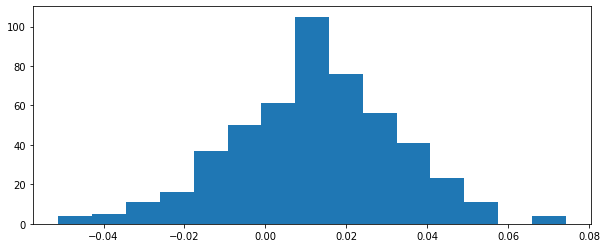

In [11]:
class_idx = 1
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([  1.,   2.,   5.,  12.,  19.,  45., 117., 262.,  17.,   5.,   6.,
          3.,   2.,   0.,   2.]),
 array([-0.07609638, -0.0662211 , -0.05634583, -0.04647055, -0.03659528,
        -0.02672   , -0.01684473, -0.00696945,  0.00290582,  0.0127811 ,
         0.02265637,  0.03253165,  0.04240692,  0.0522822 ,  0.06215747,
         0.07203275]),
 <BarContainer object of 15 artists>)

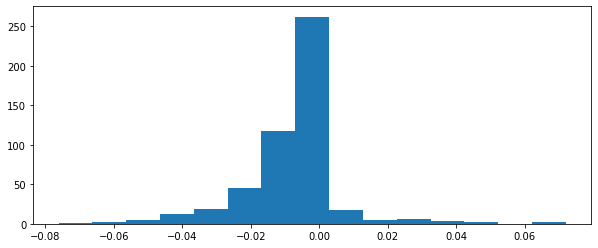

In [12]:
class_idx = 8
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([ 7., 12., 16., 84., 68., 52., 32., 19., 16., 22.,  8.,  4.,  9.,
         2.,  3.]),
 array([-0.01010499, -0.007401  , -0.004697  , -0.00199301,  0.00071098,
         0.00341497,  0.00611897,  0.00882296,  0.01152695,  0.01423094,
         0.01693494,  0.01963893,  0.02234292,  0.02504691,  0.02775091,
         0.0304549 ]),
 <BarContainer object of 15 artists>)

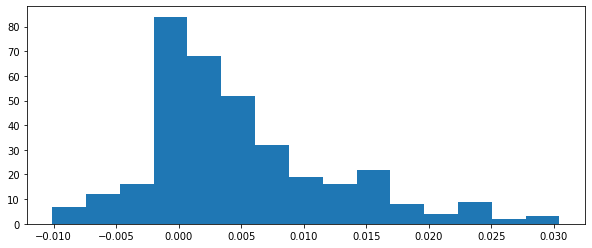

In [13]:
class_idx = 30
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

#Scores in ScoreList 7
# Score in sample_idx: 0.03234183959317356
# Support in sample_idx: 7.0


(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2.]),
 array([-0.04685856, -0.03814467, -0.02943078, -0.02071688, -0.01200299,
        -0.0032891 ,  0.00542479,  0.01413869,  0.02285258,  0.03156647,
         0.04028037,  0.04899426,  0.05770815,  0.06642205,  0.07513594,
         0.08384983]),
 <BarContainer object of 15 artists>)

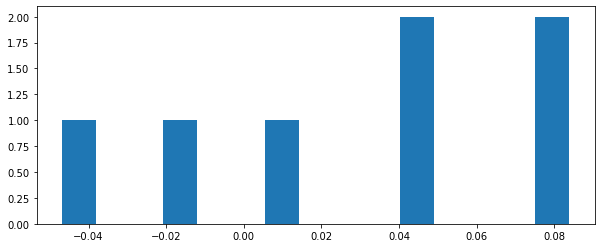

In [14]:
class_idx = 0
sample_idx = 0
score_list = memory_buffer.meta_debug[class_idx][sample_idx]

print(f"#Scores in ScoreList {len(score_list)}")
print(f"# Score in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 0]}")
print(f"# Support in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 1]}")

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

In [15]:
memory_buffer.meta_debug[class_idx].keys()

dict_keys([101, 440, 82, 110, 283, 18, 269, 248, 425, 165, 154, 135, 496, 149, 208, 464, 315, 429, 392, 379, 172, 352, 2, 287, 447, 151, 472, 314, 84, 104, 190, 176, 140, 218, 319, 277, 303, 143, 261, 241, 60, 396, 197, 452, 85, 168, 129, 139, 17, 203, 421, 335, 428, 459, 369, 483, 340, 342, 389, 326, 370, 348, 328, 382, 27, 142, 106, 282, 46, 111, 239, 264, 71, 288, 20, 390, 55, 215, 295, 262, 305, 432, 81, 351, 124, 65, 204, 173, 77, 420, 488, 42, 388, 76, 362, 416, 24, 444, 455, 316, 427, 291, 19, 415, 371, 383, 309, 145, 9, 136, 325, 313, 384, 15, 180, 11, 380, 275, 206, 422, 272, 424, 88, 297, 210, 479, 67, 105, 350, 308, 498, 411, 471, 332, 53, 296, 86, 72, 107, 365, 311, 116, 155, 186, 235, 6, 400, 103, 320, 34, 433, 274, 404, 59, 226, 153, 3, 240, 473, 441, 256, 170, 161, 201, 481, 330, 51, 56, 166, 293, 130, 202, 270, 8, 258, 485, 294, 199, 345, 334, 395, 460, 437, 228, 394, 47, 484, 359, 493, 23, 289, 401, 467, 306, 243, 127, 337, 236, 167, 263, 95, 249, 49, 134, 48, 409, 355

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [16]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True)
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [17]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 0.9578, accuracy = 0.5000, precision = 0.4682, recall = 0.4800, F1 score = 0.4621
Query set metrics: Loss = 0.6016, accuracy = 0.8125, precision = 0.9167, recall = 0.8000, F1 score = 0.8132
Query ID 1/475
Support set metrics: Loss = 0.9681, accuracy = 0.4375, precision = 0.4340, recall = 0.4100, F1 score = 0.4116
Query set metrics: Loss = 0.6031, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 1.0594, accuracy = 0.3625, precision = 0.3421, recall = 0.3333, F1 score = 0.3331
Query set metrics: Loss = 1.0159, accuracy = 0.5625, precision = 0.3400, recall = 0.5000, F1 score = 0.4000
Query ID 3/475
Support set metrics: Loss = 1.0404, accuracy = 0.3625, precision = 0.3560, recall = 0.3367, F1 score = 0.3429
Query set metrics: Loss = 0.9342, accuracy = 0.7500, precision = 0.8133, recall = 0.7500, F1 score = 

Support set metrics: Loss = 1.0261, accuracy = 0.3625, precision = 0.3701, recall = 0.3400, F1 score = 0.3529
Query set metrics: Loss = 0.6844, accuracy = 0.6875, precision = 0.5750, recall = 0.7000, F1 score = 0.6167
Query ID 36/475
Support set metrics: Loss = 0.9655, accuracy = 0.4125, precision = 0.4005, recall = 0.3867, F1 score = 0.3887
Query set metrics: Loss = 0.7468, accuracy = 0.6875, precision = 0.4267, recall = 0.5000, F1 score = 0.4587
Query ID 37/475
Support set metrics: Loss = 1.0573, accuracy = 0.3875, precision = 0.3886, recall = 0.3567, F1 score = 0.3696
Query set metrics: Loss = 0.8319, accuracy = 0.6875, precision = 0.7200, recall = 0.7267, F1 score = 0.6421
Query ID 38/475
Support set metrics: Loss = 1.0701, accuracy = 0.3625, precision = 0.3461, recall = 0.3300, F1 score = 0.3347
Query set metrics: Loss = 0.9786, accuracy = 0.3750, precision = 0.2967, recall = 0.3900, F1 score = 0.3143
Query ID 39/475
Support set metrics: Loss = 1.0124, accuracy = 0.3875, precision

Query set metrics: Loss = 1.3797, accuracy = 0.3750, precision = 0.4067, recall = 0.3867, F1 score = 0.3476
Query ID 71/475
Support set metrics: Loss = 0.9726, accuracy = 0.3875, precision = 0.3844, recall = 0.3600, F1 score = 0.3690
Query set metrics: Loss = 0.8838, accuracy = 0.5625, precision = 0.3833, recall = 0.4833, F1 score = 0.4243
Query ID 72/475
Support set metrics: Loss = 1.0032, accuracy = 0.4250, precision = 0.4228, recall = 0.4067, F1 score = 0.4103
Query set metrics: Loss = 0.7992, accuracy = 0.5625, precision = 0.4750, recall = 0.5500, F1 score = 0.4683
Query ID 73/475
Support set metrics: Loss = 0.9862, accuracy = 0.4250, precision = 0.4325, recall = 0.4033, F1 score = 0.4135
Query set metrics: Loss = 0.9467, accuracy = 0.6250, precision = 0.5400, recall = 0.5367, F1 score = 0.5133
Query ID 74/475
Support set metrics: Loss = 1.0511, accuracy = 0.3250, precision = 0.3128, recall = 0.3000, F1 score = 0.3037
Query set metrics: Loss = 0.8894, accuracy = 0.5625, precision =

Query set metrics: Loss = 0.6872, accuracy = 0.5625, precision = 0.6000, recall = 0.5500, F1 score = 0.5210
Query ID 106/475
Support set metrics: Loss = 1.0280, accuracy = 0.3750, precision = 0.3855, recall = 0.3467, F1 score = 0.3605
Query set metrics: Loss = 1.3043, accuracy = 0.4375, precision = 0.4524, recall = 0.5667, F1 score = 0.3994
Query ID 107/475
Support set metrics: Loss = 1.0656, accuracy = 0.3500, precision = 0.3487, recall = 0.3167, F1 score = 0.3303
Query set metrics: Loss = 0.8818, accuracy = 0.6250, precision = 0.6333, recall = 0.6000, F1 score = 0.5867
Query ID 108/475
Support set metrics: Loss = 0.9762, accuracy = 0.4125, precision = 0.4303, recall = 0.3867, F1 score = 0.4057
Query set metrics: Loss = 1.2688, accuracy = 0.3125, precision = 0.3524, recall = 0.2900, F1 score = 0.2438
Query ID 109/475
Support set metrics: Loss = 0.9599, accuracy = 0.4750, precision = 0.4720, recall = 0.4433, F1 score = 0.4468
Query set metrics: Loss = 1.1461, accuracy = 0.3750, precisi

Query set metrics: Loss = 0.6401, accuracy = 0.7500, precision = 0.8857, recall = 0.8400, F1 score = 0.7867
Query ID 141/475
Support set metrics: Loss = 1.1017, accuracy = 0.3375, precision = 0.3117, recall = 0.3033, F1 score = 0.3055
Query set metrics: Loss = 0.7346, accuracy = 0.6875, precision = 0.5300, recall = 0.6000, F1 score = 0.5611
Query ID 142/475
Support set metrics: Loss = 1.0663, accuracy = 0.2750, precision = 0.2808, recall = 0.2533, F1 score = 0.2653
Query set metrics: Loss = 0.8257, accuracy = 0.6250, precision = 0.7400, recall = 0.6800, F1 score = 0.6714
Query ID 143/475
Support set metrics: Loss = 1.0739, accuracy = 0.3250, precision = 0.3094, recall = 0.2967, F1 score = 0.3001
Query set metrics: Loss = 0.5802, accuracy = 0.7500, precision = 0.8300, recall = 0.7700, F1 score = 0.7476
Query ID 144/475
Support set metrics: Loss = 1.0692, accuracy = 0.3375, precision = 0.3207, recall = 0.3033, F1 score = 0.3090
Query set metrics: Loss = 1.1091, accuracy = 0.5625, precisi

Query set metrics: Loss = 1.0714, accuracy = 0.4375, precision = 0.6024, recall = 0.4733, F1 score = 0.4200
Query ID 176/475
Support set metrics: Loss = 0.9999, accuracy = 0.4000, precision = 0.4017, recall = 0.3767, F1 score = 0.3852
Query set metrics: Loss = 0.9761, accuracy = 0.5625, precision = 0.6200, recall = 0.5667, F1 score = 0.5333
Query ID 177/475
Support set metrics: Loss = 0.9623, accuracy = 0.3750, precision = 0.3480, recall = 0.3467, F1 score = 0.3417
Query set metrics: Loss = 0.7395, accuracy = 0.6250, precision = 0.7917, recall = 0.7333, F1 score = 0.6792
Query ID 178/475
Support set metrics: Loss = 0.9859, accuracy = 0.3625, precision = 0.3623, recall = 0.3467, F1 score = 0.3471
Query set metrics: Loss = 1.2803, accuracy = 0.4375, precision = 0.4400, recall = 0.4700, F1 score = 0.4533
Query ID 179/475
Support set metrics: Loss = 1.0585, accuracy = 0.3500, precision = 0.3410, recall = 0.3333, F1 score = 0.3344
Query set metrics: Loss = 0.8289, accuracy = 0.5000, precisi

Query set metrics: Loss = 1.1066, accuracy = 0.5625, precision = 0.3457, recall = 0.5500, F1 score = 0.4202
Query ID 211/475
Support set metrics: Loss = 1.0301, accuracy = 0.4125, precision = 0.4018, recall = 0.3933, F1 score = 0.3916
Query set metrics: Loss = 0.8980, accuracy = 0.4375, precision = 0.4100, recall = 0.5333, F1 score = 0.4178
Query ID 212/475
Support set metrics: Loss = 0.9989, accuracy = 0.4000, precision = 0.4325, recall = 0.3800, F1 score = 0.4026
Query set metrics: Loss = 0.7948, accuracy = 0.6875, precision = 0.6800, recall = 0.7000, F1 score = 0.6778
Query ID 213/475
Support set metrics: Loss = 1.0871, accuracy = 0.3250, precision = 0.2943, recall = 0.2933, F1 score = 0.2921
Query set metrics: Loss = 0.7399, accuracy = 0.6875, precision = 0.5667, recall = 0.5333, F1 score = 0.5276
Query ID 214/475
Support set metrics: Loss = 0.9808, accuracy = 0.3875, precision = 0.3962, recall = 0.3600, F1 score = 0.3740
Query set metrics: Loss = 1.2964, accuracy = 0.4375, precisi

Support set metrics: Loss = 1.0339, accuracy = 0.3875, precision = 0.3544, recall = 0.3567, F1 score = 0.3519
Query set metrics: Loss = 0.8520, accuracy = 0.7500, precision = 0.8476, recall = 0.7500, F1 score = 0.7435
Query ID 247/475
Support set metrics: Loss = 1.0217, accuracy = 0.3750, precision = 0.3474, recall = 0.3500, F1 score = 0.3428
Query set metrics: Loss = 1.2898, accuracy = 0.5000, precision = 0.5571, recall = 0.5833, F1 score = 0.5022
Query ID 248/475
Support set metrics: Loss = 1.0274, accuracy = 0.3875, precision = 0.3833, recall = 0.3567, F1 score = 0.3603
Query set metrics: Loss = 0.7803, accuracy = 0.6250, precision = 0.6500, recall = 0.6500, F1 score = 0.6367
Query ID 249/475
Support set metrics: Loss = 0.9713, accuracy = 0.4250, precision = 0.4375, recall = 0.4067, F1 score = 0.4177
Query set metrics: Loss = 0.9461, accuracy = 0.5625, precision = 0.6300, recall = 0.6976, F1 score = 0.6288
Query ID 250/475
Support set metrics: Loss = 1.0470, accuracy = 0.3250, preci

Support set metrics: Loss = 0.9966, accuracy = 0.4000, precision = 0.3775, recall = 0.3700, F1 score = 0.3701
Query set metrics: Loss = 0.8155, accuracy = 0.5625, precision = 0.5500, recall = 0.6600, F1 score = 0.5514
Query ID 282/475
Support set metrics: Loss = 1.0378, accuracy = 0.4000, precision = 0.3967, recall = 0.3767, F1 score = 0.3841
Query set metrics: Loss = 0.9437, accuracy = 0.7500, precision = 0.8333, recall = 0.8000, F1 score = 0.7614
Query ID 283/475
Support set metrics: Loss = 1.0926, accuracy = 0.3625, precision = 0.3227, recall = 0.3333, F1 score = 0.3258
Query set metrics: Loss = 1.0145, accuracy = 0.6875, precision = 0.7000, recall = 0.6667, F1 score = 0.6676
Query ID 284/475
Support set metrics: Loss = 1.0601, accuracy = 0.4000, precision = 0.3869, recall = 0.3733, F1 score = 0.3770
Query set metrics: Loss = 0.6664, accuracy = 0.8125, precision = 0.8048, recall = 0.8381, F1 score = 0.7981
Query ID 285/475
Support set metrics: Loss = 0.9818, accuracy = 0.4625, preci

Support set metrics: Loss = 0.9301, accuracy = 0.4375, precision = 0.4562, recall = 0.4167, F1 score = 0.4318
Query set metrics: Loss = 0.6474, accuracy = 0.7500, precision = 0.7667, recall = 0.7333, F1 score = 0.7143
Query ID 317/475
Support set metrics: Loss = 1.0015, accuracy = 0.4250, precision = 0.4294, recall = 0.4000, F1 score = 0.4116
Query set metrics: Loss = 0.8622, accuracy = 0.5000, precision = 0.2895, recall = 0.4000, F1 score = 0.3333
Query ID 318/475
Support set metrics: Loss = 1.0392, accuracy = 0.3625, precision = 0.3575, recall = 0.3400, F1 score = 0.3469
Query set metrics: Loss = 1.0402, accuracy = 0.6250, precision = 0.6357, recall = 0.6500, F1 score = 0.6114
Query ID 319/475
Support set metrics: Loss = 0.9998, accuracy = 0.4375, precision = 0.4484, recall = 0.4100, F1 score = 0.4227
Query set metrics: Loss = 1.0918, accuracy = 0.6250, precision = 0.5500, recall = 0.6500, F1 score = 0.5762
Query ID 320/475
Support set metrics: Loss = 1.0234, accuracy = 0.3750, preci

Support set metrics: Loss = 1.0536, accuracy = 0.2875, precision = 0.2781, recall = 0.2600, F1 score = 0.2666
Query set metrics: Loss = 1.3250, accuracy = 0.6250, precision = 0.6500, recall = 0.6190, F1 score = 0.6024
Query ID 352/475
Support set metrics: Loss = 1.0514, accuracy = 0.4000, precision = 0.3898, recall = 0.3733, F1 score = 0.3801
Query set metrics: Loss = 0.6985, accuracy = 0.8750, precision = 0.8750, recall = 0.9000, F1 score = 0.8533
Query ID 353/475
Support set metrics: Loss = 1.0072, accuracy = 0.3875, precision = 0.4145, recall = 0.3667, F1 score = 0.3873
Query set metrics: Loss = 1.3028, accuracy = 0.3125, precision = 0.3333, recall = 0.2000, F1 score = 0.2333
Query ID 354/475
Support set metrics: Loss = 1.0439, accuracy = 0.3500, precision = 0.3296, recall = 0.3167, F1 score = 0.3205
Query set metrics: Loss = 1.0026, accuracy = 0.6250, precision = 0.5767, recall = 0.6700, F1 score = 0.5778
Query ID 355/475
Support set metrics: Loss = 1.0018, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0866, accuracy = 0.3000, precision = 0.3216, recall = 0.2900, F1 score = 0.3018
Query set metrics: Loss = 0.9520, accuracy = 0.4375, precision = 0.4167, recall = 0.3867, F1 score = 0.4000
Query ID 387/475
Support set metrics: Loss = 1.0401, accuracy = 0.3625, precision = 0.3432, recall = 0.3367, F1 score = 0.3380
Query set metrics: Loss = 1.5111, accuracy = 0.4375, precision = 0.5167, recall = 0.4238, F1 score = 0.4203
Query ID 388/475
Support set metrics: Loss = 1.0573, accuracy = 0.3125, precision = 0.3059, recall = 0.2833, F1 score = 0.2922
Query set metrics: Loss = 0.6862, accuracy = 0.7500, precision = 0.8400, recall = 0.7833, F1 score = 0.7321
Query ID 389/475
Support set metrics: Loss = 1.0341, accuracy = 0.3500, precision = 0.3700, recall = 0.3233, F1 score = 0.3422
Query set metrics: Loss = 1.1519, accuracy = 0.6250, precision = 0.7400, recall = 0.7167, F1 score = 0.6214
Query ID 390/475
Support set metrics: Loss = 1.0037, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0615, accuracy = 0.3750, precision = 0.3637, recall = 0.3467, F1 score = 0.3535
Query set metrics: Loss = 1.2264, accuracy = 0.3750, precision = 0.2867, recall = 0.3786, F1 score = 0.2778
Query ID 422/475
Support set metrics: Loss = 0.9598, accuracy = 0.4250, precision = 0.4136, recall = 0.4000, F1 score = 0.3994
Query set metrics: Loss = 1.2867, accuracy = 0.6875, precision = 0.7600, recall = 0.7600, F1 score = 0.7467
Query ID 423/475
Support set metrics: Loss = 0.9893, accuracy = 0.4000, precision = 0.4087, recall = 0.3767, F1 score = 0.3902
Query set metrics: Loss = 0.9585, accuracy = 0.5625, precision = 0.5667, recall = 0.6167, F1 score = 0.5733
Query ID 424/475
Support set metrics: Loss = 0.9909, accuracy = 0.4250, precision = 0.3945, recall = 0.4000, F1 score = 0.3885
Query set metrics: Loss = 0.9951, accuracy = 0.5000, precision = 0.5750, recall = 0.5625, F1 score = 0.5458
Query ID 425/475
Support set metrics: Loss = 1.0054, accuracy = 0.3625, preci

Support set metrics: Loss = 1.0280, accuracy = 0.3750, precision = 0.3415, recall = 0.3500, F1 score = 0.3415
Query set metrics: Loss = 1.1539, accuracy = 0.7500, precision = 0.9000, recall = 0.7000, F1 score = 0.7485
Query ID 457/475
Support set metrics: Loss = 0.9446, accuracy = 0.4500, precision = 0.4742, recall = 0.4233, F1 score = 0.4445
Query set metrics: Loss = 0.5571, accuracy = 0.8750, precision = 0.9000, recall = 0.9000, F1 score = 0.8929
Query ID 458/475
Support set metrics: Loss = 1.0152, accuracy = 0.3875, precision = 0.4042, recall = 0.3667, F1 score = 0.3839
Query set metrics: Loss = 1.1771, accuracy = 0.6875, precision = 0.4881, recall = 0.6914, F1 score = 0.5381
Query ID 459/475
Support set metrics: Loss = 1.0090, accuracy = 0.4375, precision = 0.4127, recall = 0.4067, F1 score = 0.4058
Query set metrics: Loss = 0.8340, accuracy = 0.5000, precision = 0.6771, recall = 0.6833, F1 score = 0.5094
Query ID 460/475
Support set metrics: Loss = 1.0651, accuracy = 0.3375, preci

Support set metrics: Loss = 1.1107, accuracy = 0.3875, precision = 0.4136, recall = 0.3875, F1 score = 0.3945
Query set metrics: Loss = 0.0947, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 17/475
Support set metrics: Loss = 0.8544, accuracy = 0.5750, precision = 0.5843, recall = 0.5750, F1 score = 0.5784
Query set metrics: Loss = 0.2897, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Query ID 18/475
Support set metrics: Loss = 1.0136, accuracy = 0.4375, precision = 0.4588, recall = 0.4375, F1 score = 0.4443
Query set metrics: Loss = 0.4370, accuracy = 0.8125, precision = 0.8333, recall = 0.8667, F1 score = 0.8318
Query ID 19/475
Support set metrics: Loss = 0.9897, accuracy = 0.4500, precision = 0.5045, recall = 0.4500, F1 score = 0.4712
Query set metrics: Loss = 0.6781, accuracy = 0.8125, precision = 0.8333, recall = 0.8021, F1 score = 0.7333
Query ID 20/475
Support set metrics: Loss = 1.0704, accuracy = 0.4375, precision

Support set metrics: Loss = 1.1235, accuracy = 0.3750, precision = 0.4180, recall = 0.3750, F1 score = 0.3935
Query set metrics: Loss = 0.1638, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 53/475
Support set metrics: Loss = 1.0738, accuracy = 0.3875, precision = 0.4409, recall = 0.3875, F1 score = 0.4043
Query set metrics: Loss = 0.0609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 54/475
Support set metrics: Loss = 1.0114, accuracy = 0.3750, precision = 0.4053, recall = 0.3750, F1 score = 0.3856
Query set metrics: Loss = 0.3021, accuracy = 0.8125, precision = 0.5750, recall = 0.6167, F1 score = 0.5929
Query ID 55/475
Support set metrics: Loss = 0.9885, accuracy = 0.4625, precision = 0.4805, recall = 0.4625, F1 score = 0.4699
Query set metrics: Loss = 0.0434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 1.0197, accuracy = 0.3625, precision

Support set metrics: Loss = 0.9937, accuracy = 0.4500, precision = 0.4809, recall = 0.4500, F1 score = 0.4622
Query set metrics: Loss = 0.3132, accuracy = 0.8750, precision = 0.8250, recall = 0.8667, F1 score = 0.8167
Query ID 89/475
Support set metrics: Loss = 0.9578, accuracy = 0.4875, precision = 0.5118, recall = 0.4875, F1 score = 0.4969
Query set metrics: Loss = 0.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 1.0087, accuracy = 0.4250, precision = 0.4502, recall = 0.4250, F1 score = 0.4352
Query set metrics: Loss = 0.1374, accuracy = 0.9375, precision = 0.9375, recall = 0.9375, F1 score = 0.9286
Query ID 91/475
Support set metrics: Loss = 1.0781, accuracy = 0.3375, precision = 0.3847, recall = 0.3375, F1 score = 0.3534
Query set metrics: Loss = 0.1006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 92/475
Support set metrics: Loss = 1.0015, accuracy = 0.4250, precision

Support set metrics: Loss = 1.0194, accuracy = 0.4000, precision = 0.4312, recall = 0.4000, F1 score = 0.4107
Query set metrics: Loss = 0.0872, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 1.0179, accuracy = 0.4750, precision = 0.4990, recall = 0.4750, F1 score = 0.4860
Query set metrics: Loss = 0.1967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 125/475
Support set metrics: Loss = 1.0095, accuracy = 0.4625, precision = 0.4825, recall = 0.4625, F1 score = 0.4707
Query set metrics: Loss = 0.4580, accuracy = 0.8125, precision = 0.9250, recall = 0.8125, F1 score = 0.8368
Query ID 126/475
Support set metrics: Loss = 0.9741, accuracy = 0.4875, precision = 0.5145, recall = 0.4875, F1 score = 0.4984
Query set metrics: Loss = 0.2654, accuracy = 0.8750, precision = 0.8667, recall = 0.8667, F1 score = 0.8667
Query ID 127/475
Support set metrics: Loss = 1.1278, accuracy = 0.3375, preci

Support set metrics: Loss = 1.0478, accuracy = 0.4375, precision = 0.4959, recall = 0.4375, F1 score = 0.4581
Query set metrics: Loss = 0.2453, accuracy = 0.9375, precision = 0.9643, recall = 0.9167, F1 score = 0.9308
Query ID 159/475
Support set metrics: Loss = 1.0033, accuracy = 0.4000, precision = 0.4185, recall = 0.4000, F1 score = 0.4077
Query set metrics: Loss = 0.0743, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 1.0224, accuracy = 0.4500, precision = 0.5016, recall = 0.4500, F1 score = 0.4643
Query set metrics: Loss = 0.3879, accuracy = 0.8750, precision = 0.8333, recall = 0.9167, F1 score = 0.8250
Query ID 161/475
Support set metrics: Loss = 1.0835, accuracy = 0.3625, precision = 0.4201, recall = 0.3625, F1 score = 0.3847
Query set metrics: Loss = 0.2598, accuracy = 0.8750, precision = 0.9286, recall = 0.8810, F1 score = 0.8891
Query ID 162/475
Support set metrics: Loss = 1.0834, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0048, accuracy = 0.3500, precision = 0.3878, recall = 0.3500, F1 score = 0.3653
Query set metrics: Loss = 0.1369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 1.0069, accuracy = 0.4375, precision = 0.4827, recall = 0.4375, F1 score = 0.4541
Query set metrics: Loss = 0.0561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 195/475
Support set metrics: Loss = 0.9567, accuracy = 0.4000, precision = 0.4256, recall = 0.4000, F1 score = 0.4097
Query set metrics: Loss = 0.4047, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 1.0585, accuracy = 0.3875, precision = 0.4267, recall = 0.3875, F1 score = 0.4020
Query set metrics: Loss = 0.0870, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 197/475
Support set metrics: Loss = 1.0132, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0303, accuracy = 0.4375, precision = 0.4890, recall = 0.4375, F1 score = 0.4572
Query set metrics: Loss = 0.1049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 229/475
Support set metrics: Loss = 1.0112, accuracy = 0.4375, precision = 0.4637, recall = 0.4375, F1 score = 0.4453
Query set metrics: Loss = 0.0373, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 0.9501, accuracy = 0.5125, precision = 0.5626, recall = 0.5125, F1 score = 0.5300
Query set metrics: Loss = 0.1901, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 0.9015, accuracy = 0.4875, precision = 0.5084, recall = 0.4875, F1 score = 0.4935
Query set metrics: Loss = 0.2482, accuracy = 0.9375, precision = 0.9375, recall = 0.8750, F1 score = 0.8810
Query ID 232/475
Support set metrics: Loss = 1.0682, accuracy = 0.3875, preci

Support set metrics: Loss = 1.0185, accuracy = 0.4500, precision = 0.5029, recall = 0.4500, F1 score = 0.4704
Query set metrics: Loss = 0.1821, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 1.0559, accuracy = 0.3375, precision = 0.3856, recall = 0.3375, F1 score = 0.3548
Query set metrics: Loss = 0.1687, accuracy = 0.9375, precision = 0.9167, recall = 0.9643, F1 score = 0.9308
Query ID 265/475
Support set metrics: Loss = 1.0218, accuracy = 0.4625, precision = 0.4600, recall = 0.4625, F1 score = 0.4602
Query set metrics: Loss = 0.2151, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 1.0475, accuracy = 0.4250, precision = 0.4586, recall = 0.4250, F1 score = 0.4387
Query set metrics: Loss = 0.4529, accuracy = 0.8750, precision = 0.8667, recall = 0.9000, F1 score = 0.8722
Query ID 267/475
Support set metrics: Loss = 1.0314, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0040, accuracy = 0.4250, precision = 0.4720, recall = 0.4250, F1 score = 0.4418
Query set metrics: Loss = 0.2879, accuracy = 0.8750, precision = 0.6518, recall = 0.7143, F1 score = 0.6786
Query ID 299/475
Support set metrics: Loss = 0.9673, accuracy = 0.4875, precision = 0.5043, recall = 0.4875, F1 score = 0.4941
Query set metrics: Loss = 0.2719, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 300/475
Support set metrics: Loss = 1.0202, accuracy = 0.4375, precision = 0.4919, recall = 0.4375, F1 score = 0.4554
Query set metrics: Loss = 0.3283, accuracy = 0.9375, precision = 0.9688, recall = 0.9167, F1 score = 0.9333
Query ID 301/475
Support set metrics: Loss = 0.9483, accuracy = 0.4625, precision = 0.4743, recall = 0.4625, F1 score = 0.4645
Query set metrics: Loss = 0.1145, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 1.0341, accuracy = 0.4125, preci

Support set metrics: Loss = 1.0519, accuracy = 0.3250, precision = 0.3560, recall = 0.3250, F1 score = 0.3382
Query set metrics: Loss = 0.1794, accuracy = 0.9375, precision = 0.9375, recall = 0.9167, F1 score = 0.9143
Query ID 334/475
Support set metrics: Loss = 0.8596, accuracy = 0.4750, precision = 0.5140, recall = 0.4750, F1 score = 0.4892
Query set metrics: Loss = 0.1465, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 1.0406, accuracy = 0.3625, precision = 0.4189, recall = 0.3625, F1 score = 0.3840
Query set metrics: Loss = 0.5708, accuracy = 0.8750, precision = 0.8393, recall = 0.9143, F1 score = 0.8532
Query ID 336/475
Support set metrics: Loss = 1.0149, accuracy = 0.4125, precision = 0.4265, recall = 0.4125, F1 score = 0.4180
Query set metrics: Loss = 0.4248, accuracy = 0.9375, precision = 0.9722, recall = 0.8750, F1 score = 0.9020
Query ID 337/475
Support set metrics: Loss = 1.0789, accuracy = 0.3375, preci

Support set metrics: Loss = 0.9182, accuracy = 0.4875, precision = 0.5262, recall = 0.4875, F1 score = 0.5024
Query set metrics: Loss = 0.3206, accuracy = 0.9375, precision = 0.9583, recall = 0.8750, F1 score = 0.8939
Query ID 369/475
Support set metrics: Loss = 0.9214, accuracy = 0.4875, precision = 0.5308, recall = 0.4875, F1 score = 0.5024
Query set metrics: Loss = 0.3256, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 1.0075, accuracy = 0.4875, precision = 0.5176, recall = 0.4875, F1 score = 0.5012
Query set metrics: Loss = 0.0470, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 0.9684, accuracy = 0.4625, precision = 0.4772, recall = 0.4625, F1 score = 0.4693
Query set metrics: Loss = 0.5535, accuracy = 0.7500, precision = 0.7810, recall = 0.6935, F1 score = 0.7143
Query ID 372/475
Support set metrics: Loss = 1.0265, accuracy = 0.3375, preci

Support set metrics: Loss = 1.0226, accuracy = 0.4000, precision = 0.4310, recall = 0.4000, F1 score = 0.4099
Query set metrics: Loss = 0.3802, accuracy = 0.8125, precision = 0.9000, recall = 0.8375, F1 score = 0.8542
Query ID 404/475
Support set metrics: Loss = 1.0480, accuracy = 0.3750, precision = 0.4090, recall = 0.3750, F1 score = 0.3897
Query set metrics: Loss = 0.4882, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 1.0515, accuracy = 0.4125, precision = 0.4953, recall = 0.4125, F1 score = 0.4385
Query set metrics: Loss = 0.0867, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 1.1469, accuracy = 0.3000, precision = 0.3701, recall = 0.3000, F1 score = 0.3164
Query set metrics: Loss = 1.0683, accuracy = 0.6875, precision = 0.6875, recall = 0.7083, F1 score = 0.6643
Query ID 407/475
Support set metrics: Loss = 0.9854, accuracy = 0.4500, preci

Support set metrics: Loss = 0.9495, accuracy = 0.5250, precision = 0.5511, recall = 0.5250, F1 score = 0.5367
Query set metrics: Loss = 0.1394, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 439/475
Support set metrics: Loss = 1.0757, accuracy = 0.4375, precision = 0.4382, recall = 0.4375, F1 score = 0.4360
Query set metrics: Loss = 0.3942, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 1.0819, accuracy = 0.4250, precision = 0.4482, recall = 0.4250, F1 score = 0.4347
Query set metrics: Loss = 0.1952, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 1.0670, accuracy = 0.3750, precision = 0.4483, recall = 0.3750, F1 score = 0.3939
Query set metrics: Loss = 0.1290, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 442/475
Support set metrics: Loss = 1.0278, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0250, accuracy = 0.4000, precision = 0.4462, recall = 0.4000, F1 score = 0.4167
Query set metrics: Loss = 0.0747, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 1.0808, accuracy = 0.3875, precision = 0.4395, recall = 0.3875, F1 score = 0.4088
Query set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.2734, accuracy = 0.9153, precision = 0.9180, recall = 0.9153, F1 score = 0.9163
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.3301, accuracy = 0.9500, precision = 0.9816, recall = 0.9714, F1 score = 0.9722
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.2790, accuracy = 0.9250, precision = 0.9379, recall = 0.9500, F1 score = 0.9396
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.2465, accuracy = 0.9375, precision = 0.9619, recall = 0.9429, F1 score = 0.9469
Query set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.1710, accuracy = 0.9750, precision = 0.9738, recall = 0.9786, F1 score = 0.9755
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.2475, accuracy = 0.9500, precision = 0.9792, recall = 0.9714, F1 score = 0.9739
Query set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.1283, accuracy = 0.9750, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.4610, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.0893, accuracy = 0.9625, precision

Support set metrics: Loss = 0.2690, accuracy = 0.9500, precision = 0.9558, recall = 0.9643, F1 score = 0.9546
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.3124, accuracy = 0.9375, precision = 0.9643, recall = 0.9500, F1 score = 0.9520
Query set metrics: Loss = 0.4682, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.1863, accuracy = 0.9625, precision = 0.9690, recall = 0.9714, F1 score = 0.9682
Query set metrics: Loss = 0.0499, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 72/475
Support set metrics: Loss = 0.3432, accuracy = 0.9250, precision = 0.9558, recall = 0.9500, F1 score = 0.9434
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.3325, accuracy = 0.9500, precision

Support set metrics: Loss = 0.2353, accuracy = 0.9125, precision = 0.9337, recall = 0.9429, F1 score = 0.9354
Query set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.2098, accuracy = 0.9500, precision = 0.9612, recall = 0.9571, F1 score = 0.9544
Query set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.3307, accuracy = 0.9125, precision = 0.9567, recall = 0.9286, F1 score = 0.9363
Query set metrics: Loss = 0.2022, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.1521, accuracy = 0.9500, precision = 0.9558, recall = 0.9643, F1 score = 0.9546
Query set metrics: Loss = 0.0544, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.3001, accuracy = 0.9250, preci

Support set metrics: Loss = 0.2267, accuracy = 0.9500, precision = 0.9643, recall = 0.9643, F1 score = 0.9600
Query set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.2375, accuracy = 0.9250, precision = 0.9405, recall = 0.9429, F1 score = 0.9394
Query set metrics: Loss = 0.0800, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 141/475
Support set metrics: Loss = 0.2599, accuracy = 0.9125, precision = 0.9256, recall = 0.9286, F1 score = 0.9224
Query set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.2346, accuracy = 0.9375, preci

Support set metrics: Loss = 0.3051, accuracy = 0.9375, precision = 0.9558, recall = 0.9571, F1 score = 0.9493
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.3296, accuracy = 0.9375, precision = 0.9553, recall = 0.9500, F1 score = 0.9497
Query set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.2812, accuracy = 0.9625, precision = 0.9881, recall = 0.9786, F1 score = 0.9809
Query set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.2248, accuracy = 0.9375, precision = 0.9518, recall = 0.9571, F1 score = 0.9511
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.3112, accuracy = 0.9375, preci

Support set metrics: Loss = 0.4274, accuracy = 0.9250, precision = 0.9272, recall = 0.9357, F1 score = 0.9260
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.2771, accuracy = 0.9250, precision = 0.9413, recall = 0.9429, F1 score = 0.9345
Query set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.1928, accuracy = 0.9625, precision = 0.9762, recall = 0.9714, F1 score = 0.9711
Query set metrics: Loss = 0.1569, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.3304, accuracy = 0.9125, precision = 0.9326, recall = 0.9429, F1 score = 0.9306
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.2236, accuracy = 0.9625, preci

Support set metrics: Loss = 0.4308, accuracy = 0.9250, precision = 0.9349, recall = 0.9357, F1 score = 0.9319
Query set metrics: Loss = 0.3155, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.2510, accuracy = 0.9125, precision = 0.9254, recall = 0.9286, F1 score = 0.9199
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.2053, accuracy = 0.9500, precision = 0.9605, recall = 0.9500, F1 score = 0.9487
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.1908, accuracy = 0.9750, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.2070, accuracy = 0.9250, preci

Support set metrics: Loss = 0.3172, accuracy = 0.9375, precision = 0.9468, recall = 0.9500, F1 score = 0.9464
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.1924, accuracy = 0.9625, precision = 0.9697, recall = 0.9786, F1 score = 0.9710
Query set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.4222, accuracy = 0.9125, precision = 0.9232, recall = 0.9429, F1 score = 0.9257
Query set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.1449, accuracy = 0.9500, precision = 0.9512, recall = 0.9500, F1 score = 0.9481
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.1814, accuracy = 0.9500, preci

Support set metrics: Loss = 0.2026, accuracy = 0.9625, precision = 0.9856, recall = 0.9714, F1 score = 0.9774
Query set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.3553, accuracy = 0.9375, precision = 0.9612, recall = 0.9643, F1 score = 0.9544
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.3094, accuracy = 0.9500, precision = 0.9683, recall = 0.9643, F1 score = 0.9640
Query set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.2388, accuracy = 0.9375, precision = 0.9588, recall = 0.9500, F1 score = 0.9479
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.1946, accuracy = 0.9500, preci

Support set metrics: Loss = 0.2484, accuracy = 0.9375, precision = 0.9563, recall = 0.9500, F1 score = 0.9496
Query set metrics: Loss = 0.1339, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.1863, accuracy = 0.9750, precision = 0.9816, recall = 0.9857, F1 score = 0.9822
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.3913, accuracy = 0.9250, precision = 0.9541, recall = 0.9429, F1 score = 0.9436
Query set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.0955, accuracy = 0.9875, precision = 0.9935, recall = 0.9929, F1 score = 0.9928
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.4105, accuracy = 0.9125, preci

Support set metrics: Loss = 0.2126, accuracy = 0.9500, precision = 0.9592, recall = 0.9714, F1 score = 0.9583
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.3300, accuracy = 0.9375, precision = 0.9500, recall = 0.9571, F1 score = 0.9484
Query set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.2929, accuracy = 0.9500, precision = 0.9680, recall = 0.9571, F1 score = 0.9603
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.4611, accuracy = 0.9000, precision = 0.9161, recall = 0.9214, F1 score = 0.9145
Query set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.4236, accuracy = 0.9125, preci

Support set metrics: Loss = 0.1594, accuracy = 0.9500, precision = 0.9612, recall = 0.9571, F1 score = 0.9524
Query set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.3537, accuracy = 0.9250, precision = 0.9530, recall = 0.9500, F1 score = 0.9479
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.2379, accuracy = 0.9375, precision = 0.9445, recall = 0.9500, F1 score = 0.9435
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.2970, accuracy = 0.9500, precision = 0.9643, recall = 0.9714, F1 score = 0.9627
Query set metrics: Loss = 0.3261, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.2393, accuracy = 0.9375, preci

Support set metrics: Loss = 0.1316, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.1710, accuracy = 0.9500, precision = 0.9635, recall = 0.9714, F1 score = 0.9651
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.3478, accuracy = 0.9125, precision = 0.9333, recall = 0.9357, F1 score = 0.9292
Query set metrics: Loss = 0.1518, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.1105, accuracy = 0.9750, precision = 0.9796, recall = 0.9786, F1 score = 0.9764
Query set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.3970, accuracy = 0.9000, preci

Support set metrics: Loss = 1.0294, accuracy = 0.3375, precision = 0.3333, recall = 0.3100, F1 score = 0.3165
Query set metrics: Loss = 0.9474, accuracy = 0.6875, precision = 0.6167, recall = 0.6214, F1 score = 0.5360
Query ID 15/475
Support set metrics: Loss = 0.9876, accuracy = 0.4125, precision = 0.4236, recall = 0.3900, F1 score = 0.3997
Query set metrics: Loss = 1.3918, accuracy = 0.5000, precision = 0.4933, recall = 0.5800, F1 score = 0.4571
Query ID 16/475
Support set metrics: Loss = 1.0038, accuracy = 0.4000, precision = 0.3897, recall = 0.3733, F1 score = 0.3775
Query set metrics: Loss = 0.6757, accuracy = 0.6875, precision = 0.8444, recall = 0.6833, F1 score = 0.6762
Query ID 17/475
Support set metrics: Loss = 1.0184, accuracy = 0.4000, precision = 0.3928, recall = 0.3767, F1 score = 0.3791
Query set metrics: Loss = 0.9637, accuracy = 0.5625, precision = 0.5214, recall = 0.4714, F1 score = 0.4714
Query ID 18/475
Support set metrics: Loss = 1.0373, accuracy = 0.3250, precision

Support set metrics: Loss = 0.9721, accuracy = 0.4375, precision = 0.4348, recall = 0.4133, F1 score = 0.4125
Query set metrics: Loss = 0.8141, accuracy = 0.7500, precision = 0.5548, recall = 0.7000, F1 score = 0.6160
Query ID 51/475
Support set metrics: Loss = 1.0229, accuracy = 0.4375, precision = 0.4218, recall = 0.4133, F1 score = 0.4153
Query set metrics: Loss = 0.8947, accuracy = 0.6250, precision = 0.5167, recall = 0.5500, F1 score = 0.5233
Query ID 52/475
Support set metrics: Loss = 0.9941, accuracy = 0.4250, precision = 0.4014, recall = 0.3967, F1 score = 0.3941
Query set metrics: Loss = 0.7772, accuracy = 0.5625, precision = 0.5500, recall = 0.5833, F1 score = 0.5314
Query ID 53/475
Support set metrics: Loss = 1.0506, accuracy = 0.3125, precision = 0.3170, recall = 0.2933, F1 score = 0.3033
Query set metrics: Loss = 0.8095, accuracy = 0.6875, precision = 0.6250, recall = 0.5333, F1 score = 0.5338
Query ID 54/475
Support set metrics: Loss = 1.0037, accuracy = 0.4625, precision

Support set metrics: Loss = 1.0518, accuracy = 0.3500, precision = 0.3317, recall = 0.3233, F1 score = 0.3245
Query set metrics: Loss = 1.0114, accuracy = 0.4375, precision = 0.5167, recall = 0.4500, F1 score = 0.4238
Query ID 87/475
Support set metrics: Loss = 1.0588, accuracy = 0.3250, precision = 0.3147, recall = 0.3000, F1 score = 0.3051
Query set metrics: Loss = 0.9669, accuracy = 0.3750, precision = 0.1810, recall = 0.3000, F1 score = 0.2255
Query ID 88/475
Support set metrics: Loss = 1.0274, accuracy = 0.4375, precision = 0.4420, recall = 0.4167, F1 score = 0.4263
Query set metrics: Loss = 1.4629, accuracy = 0.4375, precision = 0.1758, recall = 0.3714, F1 score = 0.2333
Query ID 89/475
Support set metrics: Loss = 1.0548, accuracy = 0.3750, precision = 0.3838, recall = 0.3533, F1 score = 0.3653
Query set metrics: Loss = 1.1136, accuracy = 0.5625, precision = 0.4643, recall = 0.5000, F1 score = 0.4502
Query ID 90/475
Support set metrics: Loss = 1.0226, accuracy = 0.3875, precision

Support set metrics: Loss = 1.0415, accuracy = 0.3375, precision = 0.3193, recall = 0.3067, F1 score = 0.3118
Query set metrics: Loss = 1.0361, accuracy = 0.3125, precision = 0.2867, recall = 0.4400, F1 score = 0.2967
Query ID 122/475
Support set metrics: Loss = 1.1072, accuracy = 0.3125, precision = 0.3111, recall = 0.2833, F1 score = 0.2943
Query set metrics: Loss = 0.9594, accuracy = 0.5000, precision = 0.6250, recall = 0.4405, F1 score = 0.4417
Query ID 123/475
Support set metrics: Loss = 0.9549, accuracy = 0.4750, precision = 0.4786, recall = 0.4433, F1 score = 0.4418
Query set metrics: Loss = 1.0636, accuracy = 0.5625, precision = 0.4167, recall = 0.5600, F1 score = 0.4769
Query ID 124/475
Support set metrics: Loss = 1.0152, accuracy = 0.3875, precision = 0.3845, recall = 0.3667, F1 score = 0.3727
Query set metrics: Loss = 1.5605, accuracy = 0.3750, precision = 0.4417, recall = 0.4667, F1 score = 0.4333
Query ID 125/475
Support set metrics: Loss = 1.0444, accuracy = 0.2875, preci

Support set metrics: Loss = 1.0107, accuracy = 0.3750, precision = 0.3805, recall = 0.3433, F1 score = 0.3580
Query set metrics: Loss = 1.2296, accuracy = 0.4375, precision = 0.5833, recall = 0.5467, F1 score = 0.4800
Query ID 157/475
Support set metrics: Loss = 1.0665, accuracy = 0.3500, precision = 0.3371, recall = 0.3267, F1 score = 0.3306
Query set metrics: Loss = 1.1867, accuracy = 0.5000, precision = 0.4133, recall = 0.4267, F1 score = 0.4111
Query ID 158/475
Support set metrics: Loss = 1.0057, accuracy = 0.3625, precision = 0.3573, recall = 0.3267, F1 score = 0.3353
Query set metrics: Loss = 1.2327, accuracy = 0.5625, precision = 0.6500, recall = 0.6000, F1 score = 0.5822
Query ID 159/475
Support set metrics: Loss = 1.0213, accuracy = 0.3750, precision = 0.3704, recall = 0.3533, F1 score = 0.3602
Query set metrics: Loss = 0.8644, accuracy = 0.5625, precision = 0.5333, recall = 0.6067, F1 score = 0.5388
Query ID 160/475
Support set metrics: Loss = 1.0994, accuracy = 0.3625, preci

Support set metrics: Loss = 0.9020, accuracy = 0.4750, precision = 0.4913, recall = 0.4567, F1 score = 0.4671
Query set metrics: Loss = 1.5032, accuracy = 0.3750, precision = 0.3024, recall = 0.5000, F1 score = 0.3238
Query ID 192/475
Support set metrics: Loss = 1.0612, accuracy = 0.3625, precision = 0.3296, recall = 0.3400, F1 score = 0.3314
Query set metrics: Loss = 1.2796, accuracy = 0.3125, precision = 0.4750, recall = 0.3083, F1 score = 0.3472
Query ID 193/475
Support set metrics: Loss = 1.0125, accuracy = 0.4250, precision = 0.4421, recall = 0.4000, F1 score = 0.4181
Query set metrics: Loss = 0.7669, accuracy = 0.8125, precision = 0.9583, recall = 0.7708, F1 score = 0.8166
Query ID 194/475
Support set metrics: Loss = 1.0398, accuracy = 0.3500, precision = 0.3492, recall = 0.3167, F1 score = 0.3258
Query set metrics: Loss = 1.2166, accuracy = 0.5000, precision = 0.4000, recall = 0.4700, F1 score = 0.3800
Query ID 195/475
Support set metrics: Loss = 1.0861, accuracy = 0.3000, preci

Support set metrics: Loss = 1.0351, accuracy = 0.3875, precision = 0.3571, recall = 0.3700, F1 score = 0.3583
Query set metrics: Loss = 1.0220, accuracy = 0.6250, precision = 0.7143, recall = 0.5625, F1 score = 0.5808
Query ID 227/475
Support set metrics: Loss = 1.0114, accuracy = 0.3875, precision = 0.3905, recall = 0.3633, F1 score = 0.3707
Query set metrics: Loss = 1.1989, accuracy = 0.5000, precision = 0.5000, recall = 0.5000, F1 score = 0.4424
Query ID 228/475
Support set metrics: Loss = 0.9734, accuracy = 0.4375, precision = 0.4206, recall = 0.4133, F1 score = 0.4105
Query set metrics: Loss = 0.7682, accuracy = 0.5625, precision = 0.5000, recall = 0.5200, F1 score = 0.5048
Query ID 229/475
Support set metrics: Loss = 1.0680, accuracy = 0.3000, precision = 0.3104, recall = 0.2733, F1 score = 0.2879
Query set metrics: Loss = 1.3144, accuracy = 0.5000, precision = 0.5633, recall = 0.4200, F1 score = 0.4556
Query ID 230/475
Support set metrics: Loss = 0.9760, accuracy = 0.4000, preci

Support set metrics: Loss = 1.0258, accuracy = 0.3625, precision = 0.3145, recall = 0.3333, F1 score = 0.3202
Query set metrics: Loss = 0.7182, accuracy = 0.6875, precision = 0.6667, recall = 0.6300, F1 score = 0.6009
Query ID 262/475
Support set metrics: Loss = 0.9829, accuracy = 0.3625, precision = 0.3525, recall = 0.3433, F1 score = 0.3439
Query set metrics: Loss = 0.8961, accuracy = 0.4375, precision = 0.2576, recall = 0.4667, F1 score = 0.3250
Query ID 263/475
Support set metrics: Loss = 1.0457, accuracy = 0.3875, precision = 0.4034, recall = 0.3700, F1 score = 0.3812
Query set metrics: Loss = 1.5880, accuracy = 0.3125, precision = 0.2600, recall = 0.3524, F1 score = 0.2467
Query ID 264/475
Support set metrics: Loss = 0.9521, accuracy = 0.4375, precision = 0.4442, recall = 0.4067, F1 score = 0.4158
Query set metrics: Loss = 1.3362, accuracy = 0.4375, precision = 0.3667, recall = 0.3300, F1 score = 0.3267
Query ID 265/475
Support set metrics: Loss = 1.0258, accuracy = 0.3625, preci

Support set metrics: Loss = 1.0255, accuracy = 0.4000, precision = 0.3762, recall = 0.3733, F1 score = 0.3703
Query set metrics: Loss = 1.0484, accuracy = 0.5625, precision = 0.5700, recall = 0.5000, F1 score = 0.4976
Query ID 297/475
Support set metrics: Loss = 1.0860, accuracy = 0.3375, precision = 0.2863, recall = 0.3133, F1 score = 0.2977
Query set metrics: Loss = 1.1002, accuracy = 0.5000, precision = 0.4306, recall = 0.4333, F1 score = 0.4036
Query ID 298/475
Support set metrics: Loss = 0.9240, accuracy = 0.4375, precision = 0.4312, recall = 0.4167, F1 score = 0.4127
Query set metrics: Loss = 1.7359, accuracy = 0.4375, precision = 0.5556, recall = 0.6000, F1 score = 0.4667
Query ID 299/475
Support set metrics: Loss = 1.0266, accuracy = 0.3375, precision = 0.3416, recall = 0.3033, F1 score = 0.3185
Query set metrics: Loss = 0.7752, accuracy = 0.6250, precision = 0.5444, recall = 0.6667, F1 score = 0.5829
Query ID 300/475
Support set metrics: Loss = 1.0176, accuracy = 0.4250, preci

Support set metrics: Loss = 1.0668, accuracy = 0.3000, precision = 0.3079, recall = 0.2733, F1 score = 0.2861
Query set metrics: Loss = 1.0368, accuracy = 0.5625, precision = 0.2900, recall = 0.4417, F1 score = 0.3156
Query ID 332/475
Support set metrics: Loss = 0.9668, accuracy = 0.3875, precision = 0.3563, recall = 0.3667, F1 score = 0.3540
Query set metrics: Loss = 1.2147, accuracy = 0.4375, precision = 0.4167, recall = 0.4500, F1 score = 0.4070
Query ID 333/475
Support set metrics: Loss = 1.0681, accuracy = 0.3500, precision = 0.3307, recall = 0.3167, F1 score = 0.3202
Query set metrics: Loss = 0.8552, accuracy = 0.6250, precision = 0.6833, recall = 0.7000, F1 score = 0.6200
Query ID 334/475
Support set metrics: Loss = 1.0877, accuracy = 0.3625, precision = 0.3465, recall = 0.3367, F1 score = 0.3381
Query set metrics: Loss = 1.0137, accuracy = 0.6250, precision = 0.7267, recall = 0.6500, F1 score = 0.6111
Query ID 335/475
Support set metrics: Loss = 1.0190, accuracy = 0.4250, preci

Support set metrics: Loss = 1.0836, accuracy = 0.3000, precision = 0.2903, recall = 0.2700, F1 score = 0.2775
Query set metrics: Loss = 1.1136, accuracy = 0.5625, precision = 0.5833, recall = 0.4833, F1 score = 0.4900
Query ID 367/475
Support set metrics: Loss = 1.0598, accuracy = 0.3375, precision = 0.3442, recall = 0.3067, F1 score = 0.3232
Query set metrics: Loss = 1.0933, accuracy = 0.5000, precision = 0.6875, recall = 0.6667, F1 score = 0.6385
Query ID 368/475
Support set metrics: Loss = 1.0218, accuracy = 0.3750, precision = 0.3728, recall = 0.3500, F1 score = 0.3571
Query set metrics: Loss = 1.1088, accuracy = 0.5000, precision = 0.3583, recall = 0.5000, F1 score = 0.3948
Query ID 369/475
Support set metrics: Loss = 1.0434, accuracy = 0.3625, precision = 0.3324, recall = 0.3300, F1 score = 0.3254
Query set metrics: Loss = 0.6318, accuracy = 0.7500, precision = 0.8250, recall = 0.6643, F1 score = 0.7224
Query ID 370/475
Support set metrics: Loss = 0.9651, accuracy = 0.4125, preci

Support set metrics: Loss = 1.0089, accuracy = 0.4000, precision = 0.3950, recall = 0.3767, F1 score = 0.3811
Query set metrics: Loss = 1.0971, accuracy = 0.5625, precision = 0.4688, recall = 0.4500, F1 score = 0.4304
Query ID 402/475
Support set metrics: Loss = 1.0455, accuracy = 0.4250, precision = 0.4448, recall = 0.3967, F1 score = 0.4162
Query set metrics: Loss = 1.0831, accuracy = 0.6250, precision = 0.5333, recall = 0.5367, F1 score = 0.5310
Query ID 403/475
Support set metrics: Loss = 1.0006, accuracy = 0.4000, precision = 0.4189, recall = 0.3800, F1 score = 0.3938
Query set metrics: Loss = 1.0873, accuracy = 0.4375, precision = 0.4200, recall = 0.4400, F1 score = 0.4014
Query ID 404/475
Support set metrics: Loss = 0.9863, accuracy = 0.4125, precision = 0.4129, recall = 0.3833, F1 score = 0.3890
Query set metrics: Loss = 0.8155, accuracy = 0.5625, precision = 0.7200, recall = 0.7571, F1 score = 0.6032
Query ID 405/475
Support set metrics: Loss = 1.0248, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0040, accuracy = 0.3875, precision = 0.3635, recall = 0.3567, F1 score = 0.3555
Query set metrics: Loss = 0.9119, accuracy = 0.8125, precision = 0.9000, recall = 0.8333, F1 score = 0.8600
Query ID 437/475
Support set metrics: Loss = 0.9791, accuracy = 0.4500, precision = 0.4524, recall = 0.4267, F1 score = 0.4331
Query set metrics: Loss = 0.9979, accuracy = 0.6250, precision = 0.7343, recall = 0.5767, F1 score = 0.6000
Query ID 438/475
Support set metrics: Loss = 0.9424, accuracy = 0.4625, precision = 0.4600, recall = 0.4400, F1 score = 0.4444
Query set metrics: Loss = 0.9519, accuracy = 0.5625, precision = 0.6750, recall = 0.6333, F1 score = 0.6024
Query ID 439/475
Support set metrics: Loss = 1.0119, accuracy = 0.3875, precision = 0.3861, recall = 0.3567, F1 score = 0.3606
Query set metrics: Loss = 1.0031, accuracy = 0.6250, precision = 0.7000, recall = 0.6400, F1 score = 0.5514
Query ID 440/475
Support set metrics: Loss = 1.0294, accuracy = 0.3500, preci

Support set metrics: Loss = 1.0164, accuracy = 0.4250, precision = 0.4340, recall = 0.4067, F1 score = 0.4187
Query set metrics: Loss = 0.9170, accuracy = 0.5625, precision = 0.5167, recall = 0.5500, F1 score = 0.4648
Query ID 472/475
Support set metrics: Loss = 0.9840, accuracy = 0.4125, precision = 0.4430, recall = 0.3833, F1 score = 0.4098
Query set metrics: Loss = 0.9162, accuracy = 0.5625, precision = 0.5143, recall = 0.4867, F1 score = 0.4679
Query ID 473/475
Support set metrics: Loss = 1.0493, accuracy = 0.3500, precision = 0.3403, recall = 0.3233, F1 score = 0.3303
Query set metrics: Loss = 0.7894, accuracy = 0.6250, precision = 0.5733, recall = 0.5500, F1 score = 0.5310
Query ID 474/475
Support set metrics: Loss = 1.0046, accuracy = 0.4125, precision = 0.3904, recall = 0.3867, F1 score = 0.3816
Query set metrics: Loss = 1.1036, accuracy = 0.5625, precision = 0.4833, recall = 0.5000, F1 score = 0.4643
Test metrics: Loss = 1.1099, accuracy = 0.5371, precision = 0.5565, recall = 

Query set metrics: Loss = 0.9180, accuracy = 0.7500, precision = 0.8750, recall = 0.7708, F1 score = 0.8000
Query ID 31/475
Support set metrics: Loss = 1.0361, accuracy = 0.4875, precision = 0.5057, recall = 0.4600, F1 score = 0.4677
Query set metrics: Loss = 1.1069, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6875
Query ID 32/475
Support set metrics: Loss = 1.3054, accuracy = 0.4250, precision = 0.4270, recall = 0.3900, F1 score = 0.3978
Query set metrics: Loss = 1.0015, accuracy = 0.6250, precision = 0.5926, recall = 0.6852, F1 score = 0.6005
Query ID 33/475
Support set metrics: Loss = 1.1531, accuracy = 0.5250, precision = 0.4969, recall = 0.5100, F1 score = 0.4869
Query set metrics: Loss = 1.5561, accuracy = 0.6250, precision = 0.6667, recall = 0.6250, F1 score = 0.6000
Query ID 34/475
Support set metrics: Loss = 1.1503, accuracy = 0.5125, precision = 0.5092, recall = 0.5000, F1 score = 0.4936
Query set metrics: Loss = 0.9892, accuracy = 0.6875, precision =

Support set metrics: Loss = 1.2374, accuracy = 0.5250, precision = 0.5183, recall = 0.4800, F1 score = 0.4864
Query set metrics: Loss = 0.7221, accuracy = 0.8125, precision = 0.7500, recall = 0.8286, F1 score = 0.7732
Query ID 67/475
Support set metrics: Loss = 1.2604, accuracy = 0.4750, precision = 0.4611, recall = 0.4200, F1 score = 0.4363
Query set metrics: Loss = 1.1003, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 1.0729, accuracy = 0.5375, precision = 0.4806, recall = 0.5100, F1 score = 0.4813
Query set metrics: Loss = 0.6892, accuracy = 0.7500, precision = 0.8333, recall = 0.7778, F1 score = 0.7963
Query ID 69/475
Support set metrics: Loss = 1.1501, accuracy = 0.5250, precision = 0.4938, recall = 0.4900, F1 score = 0.4795
Query set metrics: Loss = 0.9203, accuracy = 0.6250, precision = 0.5556, recall = 0.5556, F1 score = 0.5370
Query ID 70/475
Support set metrics: Loss = 1.1589, accuracy = 0.4875, precision

Support set metrics: Loss = 1.1842, accuracy = 0.5000, precision = 0.5200, recall = 0.4600, F1 score = 0.4775
Query set metrics: Loss = 1.0836, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 1.1713, accuracy = 0.5750, precision = 0.5753, recall = 0.5600, F1 score = 0.5523
Query set metrics: Loss = 0.8942, accuracy = 0.6875, precision = 0.4881, recall = 0.5714, F1 score = 0.5224
Query ID 104/475
Support set metrics: Loss = 1.3352, accuracy = 0.4250, precision = 0.4422, recall = 0.3800, F1 score = 0.3917
Query set metrics: Loss = 1.0556, accuracy = 0.6250, precision = 0.6071, recall = 0.6429, F1 score = 0.6224
Query ID 105/475
Support set metrics: Loss = 1.2673, accuracy = 0.4750, precision = 0.4767, recall = 0.4300, F1 score = 0.4420
Query set metrics: Loss = 0.5930, accuracy = 0.7500, precision = 0.5000, recall = 0.6111, F1 score = 0.5407
Query ID 106/475
Support set metrics: Loss = 1.1737, accuracy = 0.5125, preci

Support set metrics: Loss = 1.1983, accuracy = 0.4750, precision = 0.4980, recall = 0.4600, F1 score = 0.4601
Query set metrics: Loss = 0.5213, accuracy = 0.8125, precision = 0.8750, recall = 0.7708, F1 score = 0.8083
Query ID 138/475
Support set metrics: Loss = 1.5352, accuracy = 0.4000, precision = 0.4141, recall = 0.3500, F1 score = 0.3686
Query set metrics: Loss = 1.5046, accuracy = 0.6250, precision = 0.5375, recall = 0.6042, F1 score = 0.5319
Query ID 139/475
Support set metrics: Loss = 1.2950, accuracy = 0.5125, precision = 0.4872, recall = 0.4800, F1 score = 0.4786
Query set metrics: Loss = 0.4368, accuracy = 0.8125, precision = 0.7778, recall = 0.8333, F1 score = 0.7741
Query ID 140/475
Support set metrics: Loss = 1.0891, accuracy = 0.5750, precision = 0.5906, recall = 0.5500, F1 score = 0.5507
Query set metrics: Loss = 0.4960, accuracy = 0.8125, precision = 0.6917, recall = 0.7500, F1 score = 0.7157
Query ID 141/475
Support set metrics: Loss = 1.3211, accuracy = 0.4875, preci

Support set metrics: Loss = 1.2201, accuracy = 0.4375, precision = 0.4551, recall = 0.4300, F1 score = 0.4196
Query set metrics: Loss = 0.8507, accuracy = 0.6875, precision = 0.7708, recall = 0.6875, F1 score = 0.7048
Query ID 173/475
Support set metrics: Loss = 1.2026, accuracy = 0.4875, precision = 0.4395, recall = 0.4500, F1 score = 0.4345
Query set metrics: Loss = 0.9472, accuracy = 0.7500, precision = 0.7037, recall = 0.7407, F1 score = 0.7000
Query ID 174/475
Support set metrics: Loss = 1.1832, accuracy = 0.5625, precision = 0.5523, recall = 0.5200, F1 score = 0.5129
Query set metrics: Loss = 0.5846, accuracy = 0.7500, precision = 0.7381, recall = 0.7262, F1 score = 0.7034
Query ID 175/475
Support set metrics: Loss = 1.2245, accuracy = 0.4625, precision = 0.4897, recall = 0.4400, F1 score = 0.4441
Query set metrics: Loss = 0.8640, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6917
Query ID 176/475
Support set metrics: Loss = 1.0921, accuracy = 0.5125, preci

Support set metrics: Loss = 1.2168, accuracy = 0.4875, precision = 0.4769, recall = 0.4700, F1 score = 0.4531
Query set metrics: Loss = 1.0239, accuracy = 0.6875, precision = 0.6296, recall = 0.6667, F1 score = 0.6111
Query ID 208/475
Support set metrics: Loss = 1.0905, accuracy = 0.5875, precision = 0.6177, recall = 0.5800, F1 score = 0.5743
Query set metrics: Loss = 1.0741, accuracy = 0.6875, precision = 0.7167, recall = 0.7167, F1 score = 0.6633
Query ID 209/475
Support set metrics: Loss = 1.2483, accuracy = 0.5375, precision = 0.5594, recall = 0.5200, F1 score = 0.5203
Query set metrics: Loss = 0.8955, accuracy = 0.6875, precision = 0.7708, recall = 0.6771, F1 score = 0.7030
Query ID 210/475
Support set metrics: Loss = 1.1673, accuracy = 0.5375, precision = 0.5324, recall = 0.5200, F1 score = 0.5127
Query set metrics: Loss = 0.8339, accuracy = 0.7500, precision = 0.9583, recall = 0.7500, F1 score = 0.8206
Query ID 211/475
Support set metrics: Loss = 1.2910, accuracy = 0.4625, preci

Support set metrics: Loss = 1.0066, accuracy = 0.5625, precision = 0.5065, recall = 0.5200, F1 score = 0.5062
Query set metrics: Loss = 1.2907, accuracy = 0.5625, precision = 0.3519, recall = 0.5556, F1 score = 0.4185
Query ID 243/475
Support set metrics: Loss = 1.0586, accuracy = 0.5625, precision = 0.5911, recall = 0.5600, F1 score = 0.5510
Query set metrics: Loss = 1.3572, accuracy = 0.6250, precision = 0.6042, recall = 0.5938, F1 score = 0.5917
Query ID 244/475
Support set metrics: Loss = 1.0927, accuracy = 0.5500, precision = 0.6096, recall = 0.5600, F1 score = 0.5711
Query set metrics: Loss = 0.3314, accuracy = 0.9375, precision = 0.8333, recall = 0.8889, F1 score = 0.8519
Query ID 245/475
Support set metrics: Loss = 1.2830, accuracy = 0.4875, precision = 0.4859, recall = 0.4600, F1 score = 0.4523
Query set metrics: Loss = 1.1969, accuracy = 0.6875, precision = 0.7315, recall = 0.7037, F1 score = 0.6767
Query ID 246/475
Support set metrics: Loss = 1.1920, accuracy = 0.4750, preci

Support set metrics: Loss = 1.0716, accuracy = 0.5750, precision = 0.5986, recall = 0.5400, F1 score = 0.5277
Query set metrics: Loss = 0.8992, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 1.2126, accuracy = 0.4875, precision = 0.5277, recall = 0.4700, F1 score = 0.4804
Query set metrics: Loss = 1.7344, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 1.2099, accuracy = 0.4750, precision = 0.4468, recall = 0.4600, F1 score = 0.4351
Query set metrics: Loss = 1.5339, accuracy = 0.5625, precision = 0.5143, recall = 0.5000, F1 score = 0.4796
Query ID 280/475
Support set metrics: Loss = 1.0993, accuracy = 0.5375, precision = 0.5251, recall = 0.5100, F1 score = 0.5082
Query set metrics: Loss = 0.6034, accuracy = 0.7500, precision = 0.6250, recall = 0.7000, F1 score = 0.6354
Query ID 281/475
Support set metrics: Loss = 1.2599, accuracy = 0.4250, preci

Support set metrics: Loss = 1.1935, accuracy = 0.5375, precision = 0.5555, recall = 0.5000, F1 score = 0.5108
Query set metrics: Loss = 0.6697, accuracy = 0.8750, precision = 0.8958, recall = 0.8750, F1 score = 0.8500
Query ID 313/475
Support set metrics: Loss = 1.1823, accuracy = 0.5125, precision = 0.5196, recall = 0.5000, F1 score = 0.4834
Query set metrics: Loss = 0.7069, accuracy = 0.8125, precision = 0.9062, recall = 0.9250, F1 score = 0.8869
Query ID 314/475
Support set metrics: Loss = 1.1578, accuracy = 0.5250, precision = 0.4960, recall = 0.4800, F1 score = 0.4759
Query set metrics: Loss = 0.4869, accuracy = 0.8125, precision = 0.8095, recall = 0.7738, F1 score = 0.7891
Query ID 315/475
Support set metrics: Loss = 1.2670, accuracy = 0.5125, precision = 0.5162, recall = 0.5000, F1 score = 0.5025
Query set metrics: Loss = 1.0882, accuracy = 0.6250, precision = 0.7095, recall = 0.5952, F1 score = 0.5991
Query ID 316/475
Support set metrics: Loss = 1.1576, accuracy = 0.5375, preci

Support set metrics: Loss = 1.2524, accuracy = 0.4625, precision = 0.4785, recall = 0.4400, F1 score = 0.4390
Query set metrics: Loss = 0.8127, accuracy = 0.7500, precision = 0.6042, recall = 0.6250, F1 score = 0.6125
Query ID 348/475
Support set metrics: Loss = 1.2221, accuracy = 0.4250, precision = 0.4557, recall = 0.3900, F1 score = 0.4061
Query set metrics: Loss = 0.9788, accuracy = 0.6875, precision = 0.5926, recall = 0.6944, F1 score = 0.6138
Query ID 349/475
Support set metrics: Loss = 1.2057, accuracy = 0.4625, precision = 0.4578, recall = 0.4300, F1 score = 0.4373
Query set metrics: Loss = 0.8025, accuracy = 0.7500, precision = 0.6429, recall = 0.6429, F1 score = 0.6259
Query ID 350/475
Support set metrics: Loss = 1.0988, accuracy = 0.5250, precision = 0.5525, recall = 0.4900, F1 score = 0.5107
Query set metrics: Loss = 0.7704, accuracy = 0.6875, precision = 0.6750, recall = 0.6771, F1 score = 0.6696
Query ID 351/475
Support set metrics: Loss = 1.2062, accuracy = 0.5000, preci

Support set metrics: Loss = 1.2810, accuracy = 0.5125, precision = 0.5165, recall = 0.4700, F1 score = 0.4697
Query set metrics: Loss = 0.9939, accuracy = 0.7500, precision = 0.6905, recall = 0.6429, F1 score = 0.6190
Query ID 383/475
Support set metrics: Loss = 1.2591, accuracy = 0.4500, precision = 0.5099, recall = 0.4400, F1 score = 0.4551
Query set metrics: Loss = 0.9281, accuracy = 0.6875, precision = 0.7571, recall = 0.6619, F1 score = 0.6619
Query ID 384/475
Support set metrics: Loss = 1.1387, accuracy = 0.5125, precision = 0.5210, recall = 0.5000, F1 score = 0.4963
Query set metrics: Loss = 1.4743, accuracy = 0.5625, precision = 0.4750, recall = 0.6167, F1 score = 0.5033
Query ID 385/475
Support set metrics: Loss = 1.2603, accuracy = 0.4250, precision = 0.4161, recall = 0.4000, F1 score = 0.3954
Query set metrics: Loss = 1.5552, accuracy = 0.5625, precision = 0.6458, recall = 0.5938, F1 score = 0.5863
Query ID 386/475
Support set metrics: Loss = 1.2570, accuracy = 0.4500, preci

Support set metrics: Loss = 1.1482, accuracy = 0.5500, precision = 0.5362, recall = 0.5200, F1 score = 0.5205
Query set metrics: Loss = 0.7456, accuracy = 0.6875, precision = 0.6833, recall = 0.7000, F1 score = 0.6705
Query ID 418/475
Support set metrics: Loss = 1.2905, accuracy = 0.4500, precision = 0.4921, recall = 0.4300, F1 score = 0.4356
Query set metrics: Loss = 0.8725, accuracy = 0.7500, precision = 0.6875, recall = 0.8125, F1 score = 0.7292
Query ID 419/475
Support set metrics: Loss = 1.2330, accuracy = 0.5375, precision = 0.5868, recall = 0.5100, F1 score = 0.5248
Query set metrics: Loss = 1.1944, accuracy = 0.5625, precision = 0.6806, recall = 0.6250, F1 score = 0.5873
Query ID 420/475
Support set metrics: Loss = 1.1920, accuracy = 0.4500, precision = 0.4192, recall = 0.4200, F1 score = 0.4072
Query set metrics: Loss = 0.9904, accuracy = 0.6875, precision = 0.4630, recall = 0.6111, F1 score = 0.5111
Query ID 421/475
Support set metrics: Loss = 1.2072, accuracy = 0.4375, preci

Support set metrics: Loss = 1.2465, accuracy = 0.4875, precision = 0.4841, recall = 0.4600, F1 score = 0.4645
Query set metrics: Loss = 0.5279, accuracy = 0.8125, precision = 0.9286, recall = 0.8333, F1 score = 0.8476
Query ID 453/475
Support set metrics: Loss = 1.1986, accuracy = 0.4875, precision = 0.5138, recall = 0.4700, F1 score = 0.4718
Query set metrics: Loss = 0.7968, accuracy = 0.6875, precision = 0.7250, recall = 0.7083, F1 score = 0.6903
Query ID 454/475
Support set metrics: Loss = 1.1375, accuracy = 0.5125, precision = 0.5919, recall = 0.5100, F1 score = 0.4935
Query set metrics: Loss = 0.7141, accuracy = 0.8125, precision = 0.7000, recall = 0.8000, F1 score = 0.7333
Query ID 455/475
Support set metrics: Loss = 1.1063, accuracy = 0.5500, precision = 0.5020, recall = 0.5300, F1 score = 0.5003
Query set metrics: Loss = 0.5530, accuracy = 0.8750, precision = 0.8611, recall = 0.8519, F1 score = 0.8508
Query ID 456/475
Support set metrics: Loss = 1.1684, accuracy = 0.4875, preci

In [18]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss4.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss4.csv


In [19]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss4.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss4.csv
